In [1]:
import numpy as np
import matplotlib.pyplot as plt


# from hnc_custom_screeningOZ_multiscale import  HNC_solver
from hnc import  HNC_solver
from qsps import *

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
        
        
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [2]:
N_bins, R_max = 2000, 10

In [3]:
def run_hnc(n_in_per_cc, T, Z, A, Zstar, num_iterations=1e3, alpha = 1e-3, tol=1e-8, c_k_guess=None , which_Tij='thermal',
            oz_type='standard', method='best', add_bridge=False, bridge='yukawa' , pseudopotential=False):
    n_in_AU = n_in_per_cc*1e6 *aB**3
    ri = QSP_HNC.rs_from_n(n_in_AU)
    qsp = QSP_HNC(Z, A, Zstar, Te, Ti, ri, Zstar*n_in_AU, which_Tij=which_Tij)

    N_species = 2
    Gamma = np.array(  [[qsp.Γii,  qsp.Γei],
                        [qsp.Γei,  qsp.Γee]])


    names = ["Ion-1", "Electron", ] 
    kappa = 1
    rhos = np.array([  3/(4*np.pi), Zstar*3/(4*np.pi) ])
    temps = np.array([qsp.Ti, qsp.Te_c])
    masses= np.array([qsp.m_i, m_e])
    hnc1 = HNC_solver(N_species, Gamma, rhos, temps, masses , tol=tol,
                     kappa_multiscale=5, num_iterations=int(num_iterations), 
                     R_max=R_max, N_bins=N_bins, names=names, dst_type=3, oz_method=oz_type)

    if pseudopotential==True:
        βvei = qsp.βvei_atomic(hnc1.r_array)
    else:
        βvei = qsp.βvei(hnc1.r_array)
    βu_r_matrix = np.array([[qsp.βvii(hnc1.r_array), βvei],
                            [βvei, qsp.βvee(hnc1.r_array)]])

    if add_bridge:
        if bridge=='ocp':
            βu_r_matrix[0,0] = βu_r_matrix[0,0] - hnc1.Bridge_function_OCP(hnc1.r_array, qsp.Γii)
        elif bridge=='yukawa':
            βu_r_matrix[0,0] = βu_r_matrix[0,0] - hnc1.Bridge_function_Yukawa(hnc1.r_array, qsp.Γii, qsp.get_κ())
    hnc1.set_βu_matrix(βu_r_matrix)
    hnc1.initialize_c_k()
#     print("c asymm: ", hnc1.c_s_k_matrix[1,0]/hnc1.c_s_k_matrix[0,1])
    if c_k_guess is not None:
        for i in range(N_species):
            for j in range(N_species):
                if (c_k_guess[i,j]!=np.zeros(hnc1.N_bins)).all():
#                 if i==j:
                    hnc1.c_k_matrix[i,j] = c_k_guess[i,j]
                    hnc1.c_r_matrix[i,j] = hnc1.FT_k_2_r(hnc1.c_k_matrix[i,j])
                    hnc1.c_s_k_matrix[i,j] = hnc1.c_k_matrix[i,j] + hnc1.βu_l_k_matrix[i,j]
                    hnc1.c_s_r_matrix[i,j] = hnc1.c_r_matrix[i,j] + hnc1.βu_l_r_matrix[i,j]

#     print("c asymm: ", hnc1.c_s_k_matrix[1,0]/hnc1.c_s_k_matrix[0,1])
    hnc1.set_C_matrix()
    hnc1.HNC_solve(alpha_method=method, alpha_Picard = alpha, alpha_oz = 0e-4, h_max=1e8)

    return hnc1, qsp

In [46]:
def run_mixture_hnc(n_in_per_cc, T, Z1,Z2, A1,A2, Zstar1,Zstar2, num_iterations=1e3, alpha = 1e-3, tol=1e-8, c_k_guess=None , which_Tij='thermal',
            oz_type='standard', method='best', add_bridge=False, bridge='yukawa' , pseudopotential=False ):
    n_in_AU = n_in_per_cc*1e6 *aB**3
    ne = (Zstar1 + Zstar2)*n_in_AU
    ri = QSP_HNC.rs_from_n(n_in_AU)
    qsp_i1 = QSP_HNC(Z1, A1, Zstar1, Te, Ti, ri, ne, which_Tij=which_Tij)
    qsp_i2 = QSP_HNC(Z2, A2, Zstar2, Te, Ti, ri, ne, which_Tij=which_Tij)

    N_species = 3
    Γ0 = 1/Ti/ri
    Gamma = np.array(  [[Zstar1**2*Γ0,      Zstar1*Zstar2*Γ0, qsp_i1.Γei],
                        [Zstar1*Zstar2*Γ0,  Zstar2**2*Γ0,     qsp_i2.Γei],
                        [qsp_i1.Γei,        qsp_i2.Γei,       qsp_i2.Γee]])


    names = ["Ion-1", "Ion-2", "Electron", ] 
    rhos = np.array([  3/(4*np.pi), 3/(4*np.pi), (Zstar1+Zstar2)*3/(4*np.pi) ])
    temps = np.array([qsp_i1.Ti, qsp_i2.Ti, qsp_i1.Te_c])
    masses= np.array([qsp_i1.m_i, qsp_i2.m_i , m_e])
    hnc1 = HNC_solver(N_species, Gamma, rhos, temps, masses , tol=tol,
                     kappa_multiscale=1, num_iterations=int(num_iterations), 
                     R_max=R_max, N_bins=N_bins, names=names, dst_type=3, oz_method=oz_type)
    
    if pseudopotential==True:
        βvei1 = qsp_i1.βvei_atomic(hnc1.r_array)
        βvei2 = qsp_i2.βvei_atomic(hnc1.r_array)
    else:
        βvei1 = qsp_i1.βvei(hnc1.r_array)
        βvei2 = qsp_i2.βvei(hnc1.r_array)
        
    βvii_0 = qsp_i1.βvii(hnc1.r_array)/Zstar1**2
    βu_r_matrix = np.array([[βvii_0*Zstar1**2,         βvii_0*Zstar1*Zstar2,  βvei1],
                            [βvii_0*Zstar1*Zstar2,     βvii_0*Zstar2**2,      βvei2],
                            [βvei1,       βvei2, qsp_i1.βvee(hnc1.r_array)]])

#     if add_bridge:
#         if bridge=='ocp':
#             βu_r_matrix[0,0] = βu_r_matrix[0,0] - hnc1.Bridge_function_OCP(hnc1.r_array, qsp.Γii)
#         elif bridge=='yukawa':
#             βu_r_matrix[0,0] = βu_r_matrix[0,0] - hnc1.Bridge_function_Yukawa(hnc1.r_array, qsp.Γii, qsp.get_κ())
    hnc1.set_βu_matrix(βu_r_matrix)
    hnc1.initialize_c_k()
#     print("c asymm: ", hnc1.c_s_k_matrix[1,0]/hnc1.c_s_k_matrix[0,1])
    if c_k_guess is not None:
        for i in range(N_species):
            for j in range(N_species):
                if (c_k_guess[i,j]!=np.zeros(hnc1.N_bins)).all():
#                 if i==j:
                    hnc1.c_k_matrix[i,j] = c_k_guess[i,j]
                    hnc1.c_r_matrix[i,j] = hnc1.FT_k_2_r(hnc1.c_k_matrix[i,j])
                    hnc1.c_s_k_matrix[i,j] = hnc1.c_k_matrix[i,j] + hnc1.βu_l_k_matrix[i,j]
                    hnc1.c_s_r_matrix[i,j] = hnc1.c_r_matrix[i,j] + hnc1.βu_l_r_matrix[i,j]

#     print("c asymm: ", hnc1.c_s_k_matrix[1,0]/hnc1.c_s_k_matrix[0,1])
    hnc1.set_C_matrix()
    hnc1.HNC_solve(alpha_method=method, alpha_Picard = alpha, alpha_oz = 0e-4, h_max=1e8)

    return hnc1, qsp_i1, qsp_i2

In [47]:
def run_hnc_one_ion(n_in_per_cc, T, Z, A, Zstar, num_iterations=1e3, alpha = 1e-3,method='best',oz_type='standard', which_Tij='thermal' ):
    n_in_AU = n_in_per_cc*1e6 *aB**3
    ri = QSP_HNC.rs_from_n(n_in_AU)
    qsp = QSP_HNC(Z, A, Zstar, Te, Ti, ri, Zstar*n_in_AU, which_Tij=which_Tij)

    N_species = 1
    Gamma = np.array(  [[qsp.Γii]])


    names = ["i"] 
    kappa = 1
    rho = np.array([  3/(4*np.pi)])
    temps = np.array([[qsp.Ti]])
    masses= np.array([[qsp.m_i]])
    hnc1 = HNC_solver(N_species, Gamma,rho, temps,masses, kappa=kappa, tol=1e-5,
                     kappa_multiscale=1, num_iterations=int(num_iterations), 
                     R_max=R_max, N_bins=N_bins, names=names, dst_type=3,oz_method=oz_type)

    βu_r_matrix = np.array([[qsp.βvii(hnc1.r_array)]])

    hnc1.set_βu_matrix(βu_r_matrix)
    hnc1.initialize_c_k()
    hnc1.set_C_matrix()
    hnc1.HNC_solve(alpha_method=method, alpha_Picard = alpha, alpha_oz = 0e-4, h_max=1e4)
    return hnc1, qsp

def run_hnc_one_electron(n_in_per_cc, T, Z, A, Zstar, num_iterations=1e3, alpha = 1e-3,method='best' ,oz_type='standard', which_Tij='thermal'):
    ri = QSP_HNC.rs_from_n(n_in_per_cc*1e6 *aB**3)
    qsp = QSP_HNC(Z, A, Zstar, Te, Ti, ri, Zstar*n, which_Tij=which_Tij)

    N_species = 1
    Gamma = np.array(  [[qsp.Γii]])


    names = ["e"] 
    kappa = 1
    rho = np.array([  Zstar*3/(4*np.pi)])
    temps = np.array([[qsp.Te_c]])
    masses= np.array([[m_e]])
    hnc1 = HNC_solver(N_species, Gamma,rho, temps,masses, kappa=kappa, tol=1e-5,
                     kappa_multiscale=1, num_iterations=int(num_iterations), 
                     R_max=R_max, N_bins=N_bins, names=names, dst_type=3,oz_method=oz_type)

    βu_r_matrix = np.array([[qsp.βvee(hnc1.r_array)]])

    hnc1.set_βu_matrix(βu_r_matrix)
    hnc1.initialize_c_k()
    hnc1.set_C_matrix()
    hnc1.HNC_solve(alpha_method=method, alpha_Picard = alpha, alpha_oz = 0e-4, h_max=1e4)
    return hnc1, qsp



In [48]:
def run_hnc_TF(n_in_per_cc, T, Z, A, Zstar,κ = 1, num_iterations=1e3, alpha = 1e-3,method='best',oz_type='standard', which_Tij='thermal' ):
    n_in_AU = n_in_per_cc*1e6 *aB**3
    ri = QSP_HNC.rs_from_n(n_in_AU)
    qsp = QSP_HNC(Z, A, Zstar, Te, Ti, ri, Zstar*n_in_AU, which_Tij=which_Tij)

    N_species = 1
    Gamma = np.array(  [[qsp.Γii]])


    names = ["i"] 
    kappa = 1
    rho = np.array([  3/(4*np.pi)])
    temps = np.array([[qsp.Ti]])
    masses= np.array([[qsp.m_i]])
#     hnc1 = HNC_solver(N_species, Gamma,rho, temps,masses, kappa=kappa, tol=1e-5,
#                      kappa_multiscale=1, num_iterations=int(num_iterations), 
#                      R_max=5, N_bins=N_bins, names=names, dst_type=3)
    temps = np.array([[qsp.Te_c]])
    masses= np.array([[m_e]])
    hnc1 = HNC_solver(N_species, Gamma,rho, temps,masses, kappa=kappa, tol=1e-5,
                     kappa_multiscale=1, num_iterations=int(num_iterations), 
                     R_max=R_max, N_bins=N_bins, names=names, dst_type=3, oz_method=oz_type)

    βu_r_matrix = np.array([[ qsp.Γii/hnc1.r_array *np.exp(-κ*hnc1.r_array)  ]])

    hnc1.set_βu_matrix(βu_r_matrix)
    hnc1.initialize_c_k()
    hnc1.set_C_matrix()
    hnc1.HNC_solve(alpha_method=method, alpha_Picard = alpha, alpha_oz = 0e-4, h_max=1e4)
    return hnc1, qsp


# Priority 1

## Cu-H mixture (HCu1)

In [49]:
# ni = 1.68e+22 # per cc
# Te = 1*eV 
# Ti   = 1*eV 
# Z1, A1, Zstar1 = 29, 63.546, 1.0010889715987994 # C
# Z2, A2, Zstar2 = 1, 1 , 0.40970693987287754  # H

## C-H mixture (CH1)

In [50]:
ni = 4.63e23 # per cc
Te = 2*eV 
Ti   = 2*eV 
Z1, A1, Zstar1 = 6, 12, 0.8438527618887307 # C
Z2, A2, Zstar2 = 1, 1 , 0.556880186479285  # H

In [54]:
CH1, CH1qsp1, CH1qsp2  = run_mixture_hnc(ni, Te, Z1,Z2, A1,A2, Zstar1,Zstar2 ,method='fixed',alpha=0.5,num_iterations=1e3, pseudopotential=False)#, c_s_r_guess=c_s_r_guess)
CH1SVT, CH1qsp1, CH1qsp2  = run_mixture_hnc(ni, Te, Z1,Z2, A1,A2, Zstar1,Zstar2 ,method='fixed',alpha=0.5,num_iterations=1e3, oz_type='svt', pseudopotential=False)#, c_s_r_guess=c_s_r_guess)
CH1_ps, CH1qsp1, CH1qsp2  = run_mixture_hnc(ni, Te, Z1,Z2, A1,A2, Zstar1,Zstar2 ,method='fixed',alpha=0.5,num_iterations=1e3, pseudopotential=True)#, c_s_r_guess=c_s_r_guess)
CH1SVT_ps, CH1qsp1, CH1qsp2  = run_mixture_hnc(ni, Te, Z1,Z2, A1,A2, Zstar1,Zstar2 ,method='fixed',alpha=0.5,num_iterations=1e3, oz_type='svt', pseudopotential=True)#, c_s_r_guess=c_s_r_guess)

Λei = 0.294
Λee = 0.416
Λei adjusted with R = 0.294
Γii=6.393, Γie=-0.695, Γee=0.824 
r_i=1.515
r_e=1.354
θ  =7.32e-02
Λei = 0.294
Λee = 0.416
Λei adjusted with R = 0.294
Γii=2.784, Γie=-0.459, Γee=0.824 
r_i=1.515
r_e=1.354
θ  =7.32e-02
0: Err in c_r: 8.18e+00, OZ: 4.09e-02, HNC: 2.25e-02, tot: 8.18e+00, tot: 8.49e+00
1: Err in c_r: 4.25e+00, OZ: 3.48e-02, HNC: 1.44e-02, tot: 4.25e+00, tot: 4.41e+00
2: Err in c_r: 2.20e+00, OZ: 2.98e-02, HNC: 1.16e-02, tot: 2.20e+00, tot: 2.30e+00
3: Err in c_r: 1.15e+00, OZ: 2.56e-02, HNC: 1.05e-02, tot: 1.15e+00, tot: 1.21e+00
4: Err in c_r: 6.05e-01, OZ: 2.19e-02, HNC: 9.72e-03, tot: 6.05e-01, tot: 6.51e-01
5: Err in c_r: 3.25e-01, OZ: 1.88e-02, HNC: 8.94e-03, tot: 3.25e-01, tot: 3.62e-01
6: Err in c_r: 1.81e-01, OZ: 1.60e-02, HNC: 8.02e-03, tot: 1.81e-01, tot: 2.12e-01
7: Err in c_r: 1.06e-01, OZ: 1.36e-02, HNC: 7.02e-03, tot: 1.06e-01, tot: 1.33e-01
8: Err in c_r: 6.65e-02, OZ: 1.15e-02, HNC: 6.01e-03, tot: 6.65e-02, tot: 8.94e-02
9: Err in c_r: 

5: Err in c_r: 3.22e-01, OZ: 1.73e-02, HNC: 9.83e-03, tot: 3.22e-01, tot: 3.55e-01
6: Err in c_r: 1.78e-01, OZ: 1.45e-02, HNC: 8.85e-03, tot: 1.78e-01, tot: 2.05e-01
7: Err in c_r: 1.02e-01, OZ: 1.20e-02, HNC: 7.74e-03, tot: 1.02e-01, tot: 1.25e-01
8: Err in c_r: 6.25e-02, OZ: 9.92e-03, HNC: 6.61e-03, tot: 6.25e-02, tot: 8.14e-02
9: Err in c_r: 4.07e-02, OZ: 8.13e-03, HNC: 5.53e-03, tot: 4.07e-02, tot: 5.61e-02
10: Err in c_r: 2.81e-02, OZ: 6.63e-03, HNC: 4.56e-03, tot: 2.81e-02, tot: 4.05e-02
11: Err in c_r: 2.02e-02, OZ: 5.38e-03, HNC: 3.72e-03, tot: 2.02e-02, tot: 3.01e-02
12: Err in c_r: 1.50e-02, OZ: 4.35e-03, HNC: 3.01e-03, tot: 1.50e-02, tot: 2.29e-02
13: Err in c_r: 1.14e-02, OZ: 3.51e-03, HNC: 2.42e-03, tot: 1.14e-02, tot: 1.76e-02
14: Err in c_r: 8.80e-03, OZ: 2.82e-03, HNC: 1.94e-03, tot: 8.80e-03, tot: 1.37e-02
15: Err in c_r: 6.84e-03, OZ: 2.26e-03, HNC: 1.55e-03, tot: 6.84e-03, tot: 1.07e-02
16: Err in c_r: 5.34e-03, OZ: 1.81e-03, HNC: 1.24e-03, tot: 5.34e-03, tot: 8.39e-

25: Err in c_r: 1.28e-03, OZ: 5.09e-04, HNC: 9.53e-05, tot: 1.28e-03, tot: 2.12e-03
26: Err in c_r: 1.06e-03, OZ: 4.21e-04, HNC: 7.87e-05, tot: 1.06e-03, tot: 1.74e-03
27: Err in c_r: 8.72e-04, OZ: 3.48e-04, HNC: 6.50e-05, tot: 8.72e-04, tot: 1.44e-03
28: Err in c_r: 7.19e-04, OZ: 2.88e-04, HNC: 5.37e-05, tot: 7.19e-04, tot: 1.19e-03
29: Err in c_r: 5.93e-04, OZ: 2.38e-04, HNC: 4.44e-05, tot: 5.93e-04, tot: 9.79e-04
30: Err in c_r: 4.90e-04, OZ: 1.97e-04, HNC: 3.67e-05, tot: 4.90e-04, tot: 8.08e-04
31: Err in c_r: 4.04e-04, OZ: 1.62e-04, HNC: 3.03e-05, tot: 4.04e-04, tot: 6.67e-04
32: Err in c_r: 3.33e-04, OZ: 1.34e-04, HNC: 2.50e-05, tot: 3.33e-04, tot: 5.51e-04
33: Err in c_r: 2.75e-04, OZ: 1.11e-04, HNC: 2.07e-05, tot: 2.75e-04, tot: 4.55e-04
34: Err in c_r: 2.27e-04, OZ: 9.16e-05, HNC: 1.71e-05, tot: 2.27e-04, tot: 3.75e-04
35: Err in c_r: 1.88e-04, OZ: 7.57e-05, HNC: 1.41e-05, tot: 1.88e-04, tot: 3.10e-04
36: Err in c_r: 1.55e-04, OZ: 6.25e-05, HNC: 1.16e-05, tot: 1.55e-04, tot: 2

31: Err in c_r: 3.20e-04, OZ: 1.22e-04, HNC: 2.40e-05, tot: 3.20e-04, tot: 5.22e-04
32: Err in c_r: 2.61e-04, OZ: 9.94e-05, HNC: 1.96e-05, tot: 2.61e-04, tot: 4.26e-04
33: Err in c_r: 2.13e-04, OZ: 8.12e-05, HNC: 1.60e-05, tot: 2.13e-04, tot: 3.48e-04
34: Err in c_r: 1.74e-04, OZ: 6.64e-05, HNC: 1.31e-05, tot: 1.74e-04, tot: 2.84e-04
35: Err in c_r: 1.42e-04, OZ: 5.43e-05, HNC: 1.07e-05, tot: 1.42e-04, tot: 2.32e-04
36: Err in c_r: 1.16e-04, OZ: 4.43e-05, HNC: 8.73e-06, tot: 1.16e-04, tot: 1.90e-04
37: Err in c_r: 9.49e-05, OZ: 3.62e-05, HNC: 7.13e-06, tot: 9.49e-05, tot: 1.55e-04
38: Err in c_r: 7.75e-05, OZ: 2.96e-05, HNC: 5.83e-06, tot: 7.75e-05, tot: 1.27e-04
39: Err in c_r: 6.33e-05, OZ: 2.42e-05, HNC: 4.76e-06, tot: 6.33e-05, tot: 1.03e-04
40: Err in c_r: 5.17e-05, OZ: 1.98e-05, HNC: 3.89e-06, tot: 5.17e-05, tot: 8.45e-05
41: Err in c_r: 4.23e-05, OZ: 1.61e-05, HNC: 3.18e-06, tot: 4.23e-05, tot: 6.90e-05
42: Err in c_r: 3.45e-05, OZ: 1.32e-05, HNC: 2.60e-06, tot: 3.45e-05, tot: 5

In [60]:
CH1SVT.h_r_matrix[0,0]/CH1SVT_ps.h_r_matrix[0,0]

array([1.        , 1.        , 1.        , ..., 1.18471107, 1.18471107,
       1.18471107])

In [55]:
# CH1.plot_convergence_uex()
# CH1SVT.plot_convergence_uex()

In [56]:
# CH1.plot_species_convergence_g(n_slices= int(len(CH1.h_list)/1)  )
# CH1SVT.plot_species_convergence_g(n_slices= int(len(CH1.h_list)/1)  )

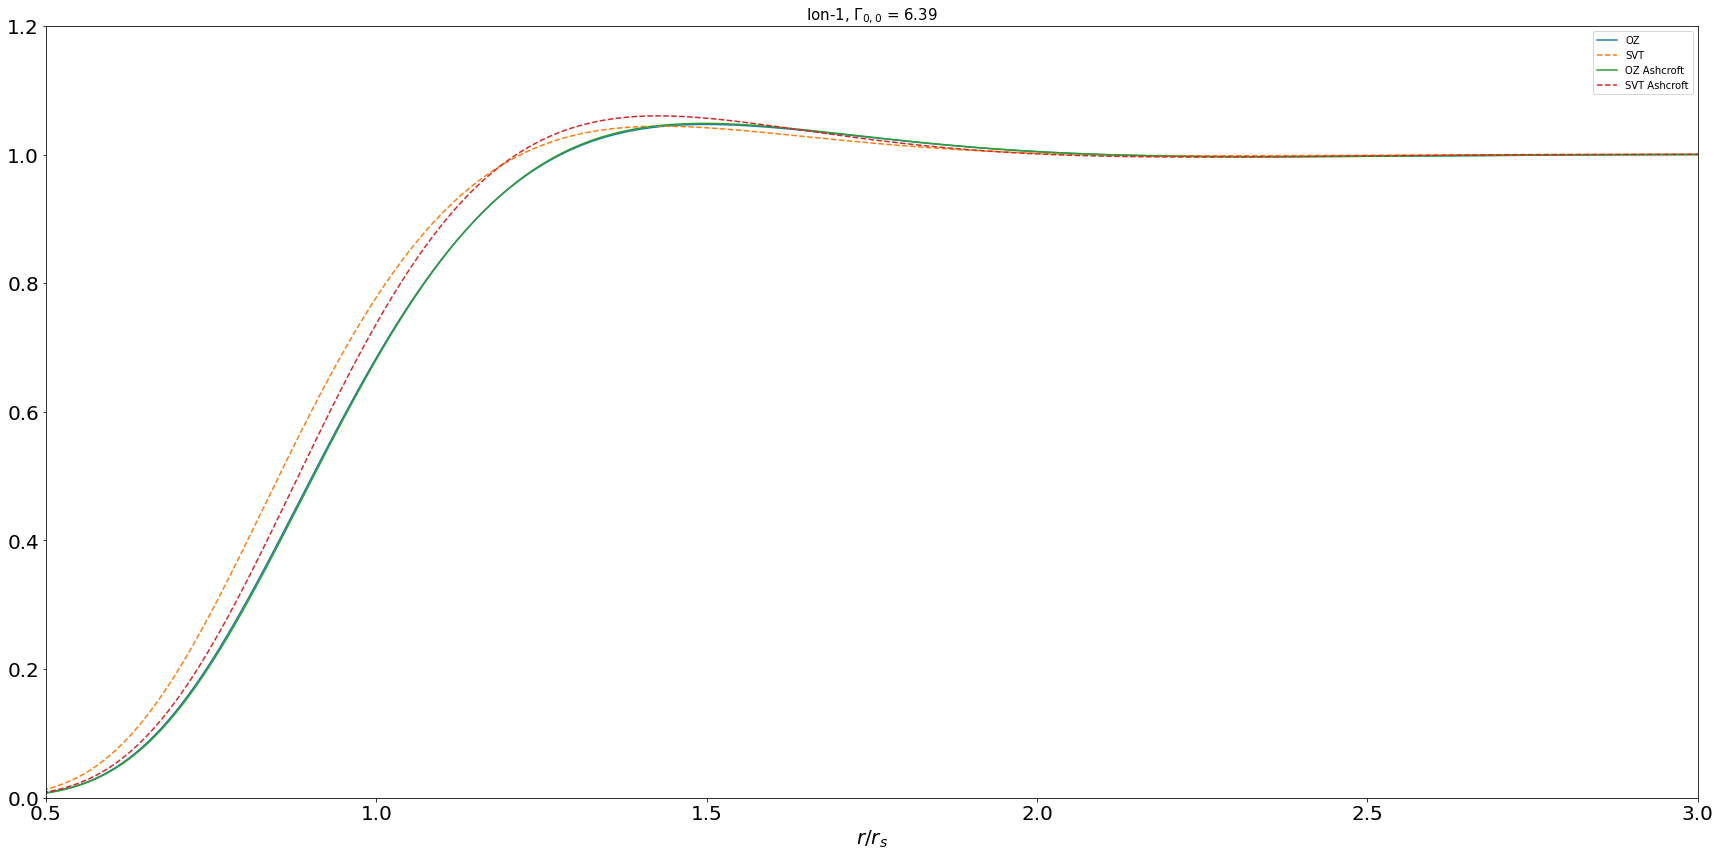

In [71]:
# fig, axs = plt.subplots(ncols=CH1.N_species, nrows=CH1.N_species, figsize=(8*CH1.N_species,4*CH1.N_species))
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(8*CH1.N_species,4*CH1.N_species))
axs = np.array([[axs]])
for i in range(1):#CH1.N_species):
            for j in range(1):#CH1.N_species):
                axs[i,j].plot(CH1.r_array, CH1.h_r_matrix[i,j]+1, '-',label='OZ')
                axs[i,j].plot(CH1SVT.r_array, CH1SVT.h_r_matrix[i,j]+1,'--', label='SVT')
                axs[i,j].plot(CH1_ps.r_array, CH1_ps.h_r_matrix[i,j]+1,'-', label='OZ Ashcroft')
                axs[i,j].plot(CH1SVT_ps.r_array, CH1SVT_ps.h_r_matrix[i,j]+1,'--', label='SVT Ashcroft')
                axs[i,j].set_title(CH1.name_matrix[i][j] + r", $\Gamma_{{ {0},{1} }}$ = {2:.2f}".format(i,j,CH1.Gamma[i][j]) ,fontsize=15)
                axs[i,j].set_ylim(0,1.2)
                axs[i,j].set_xlim(0.5,3)
                axs[i,j].tick_params(labelsize=20)
                axs[-1,j].set_xlabel(r"$r/r_s$",fontsize=20)

axs[0,0].legend()
fig.tight_layout()

### Invert HNC and get βueff

In [75]:
CH1.invert_HNC([2])
CH1_ps.invert_HNC([2])
CH1SVT.invert_HNC([2])
CH1SVT_ps.invert_HNC([2])

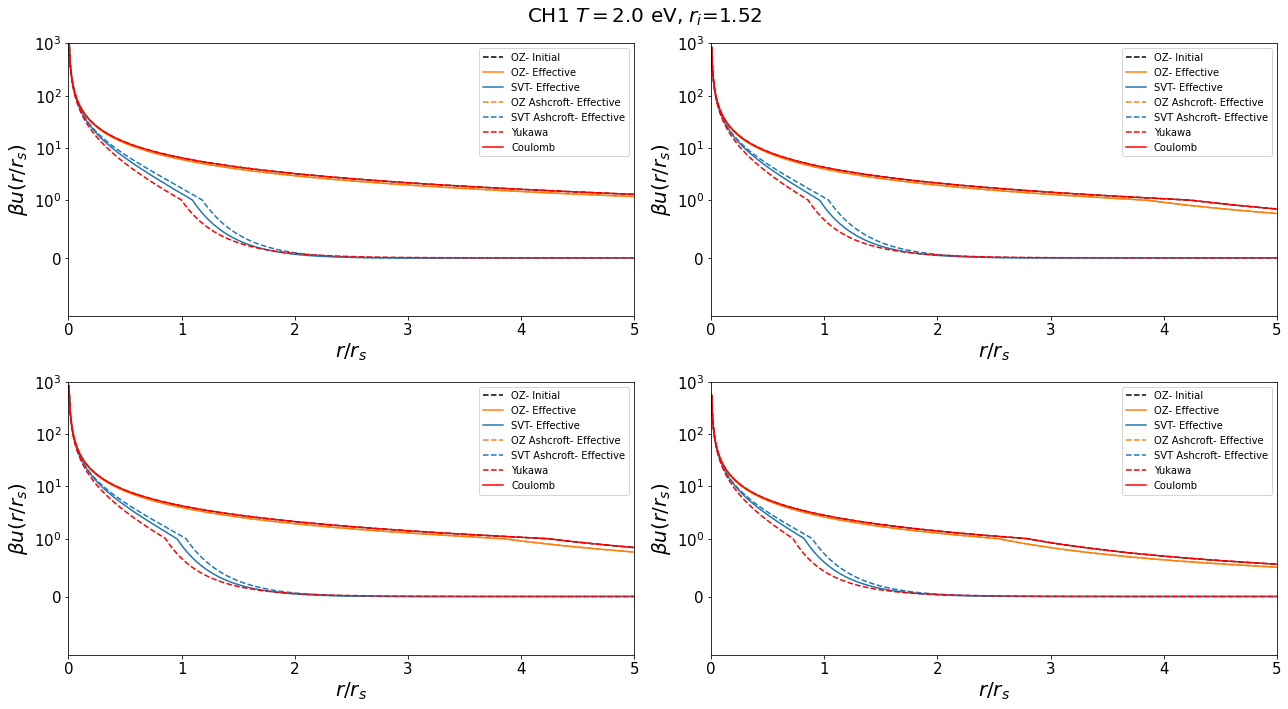

In [80]:
fig, axs = plt.subplots(2,2,figsize=(18,10),facecolor='w')
fig.suptitle(r"CH1 $T=${0:.1f} eV, $r_i$={1:.2f}".format(Te/eV,CH1qsp1.ri), fontsize=20)

yukawa_matrix = (CH1.Gamma[:,:,np.newaxis]/CH1.r_array * np.exp(-CH1.r_array*CH1qsp1.get_κ())[np.newaxis,np.newaxis,:] ) [:-1,:-1]
coulomb_matrix = (CH1.Gamma[:,:,np.newaxis]/CH1.r_array) [:-1,:-1]
for i in range(CH1.Neff_species):
            for j in range(CH1.Neff_species):
                axs[i,j].plot(CH1.r_array, CH1.βu_r_matrix[i,j], 'k--',label='OZ- Initial')
                
                axs[i,j].plot(CH1.r_array, CH1.βueff_r_matrix[i,j],color=colors[1], label='OZ- Effective')
                axs[i,j].plot(CH1.r_array, CH1SVT.βueff_r_matrix[i,j],color=colors[0], label='SVT- Effective')
                axs[i,j].plot(CH1.r_array, CH1_ps.βueff_r_matrix[i,j],'--',color=colors[1], label='OZ Ashcroft- Effective')
                axs[i,j].plot(CH1.r_array, CH1SVT_ps.βueff_r_matrix[i,j],'--',color=colors[0], label='SVT Ashcroft- Effective')
                
                axs[i,j].plot(CH1.r_array, yukawa_matrix[i,j],'r--', label="Yukawa")
                axs[i,j].plot(CH1.r_array, coulomb_matrix[i,j],'r-', label="Coulomb")
                
#                 axs[i,j].plot(CH1SVT.r_array, CH1SVT.h_r_matrix[i,j]+1, label='SVT OZ')
#                 axs[i,j].set_title(CH1.name_matrix[i][j] + r", $\Gamma_{{ {0},{1} }}$ = {2:.2f}".format(i,j,CH1.Gamma[i][j]) ,fontsize=15)
                axs[i,j].set_ylim(-1,1e3)
                axs[i,j].tick_params(labelsize=20)
                axs[-1,j].set_xlabel(r"$r/r_s$",fontsize=20)
                axs[i,j].set_ylabel(r'$\beta u(r/r_s)$',fontsize=20)
                axs[i,j].set_xlabel(r'$r/r_s$',fontsize=20)
               
                axs[i,j].set_xlim(0,5)
                axs[i,j].set_yscale('symlog',linthresh=1)
                axs[i,j].tick_params(labelsize=15)
                axs[i,j].legend(fontsize=10)
fig.tight_layout()

In [111]:
from scipy.optimize import curve_fit

class βu_fit():
    def __init__(self, func, r_array, y_data):
        self.r = r_array
        self.y = y_data
        self.y_vals = curve_fit(func, r_array, y_data, maxfev=int(1e4))
        self.y_fit  = func(CH1.r_array, *self.y_vals[0])
        self.err = np.linalg.norm(self.y_fit-self.y)
        print(func.__name__ + " error: {0:.3e} ".format(self.err))

In [127]:

def yukawa(r, Γ, κ, p):
    return  Γ/r*np.exp(-κ*r)

def yukawa_remaining(r,a,b,c,d):
    return 1/(a+b*np.exp(c*(r-d)))

def LJ(r, a,b,m,n):
    return  1/(a*r**m + b/r**n) #+ v0

def yukawa_friedel(r, Γ, κ1, a,κ2, k,  δ, v0):
    return  Γ/r*np.exp(-κ1*r) + a/r**3*np.exp(-κ2*r)*np.cos(k*r+δ) + v0

def yukawa_plus(r, a ,b ,c, d):
    return a/r*np.exp(-b*r)/(1+np.exp(c*(r-d)))

def yukawa_plus_gaussian(r, a ,b ,c, d ,e, f, g):
    return  a/r*np.exp(-b*r)/(1+np.exp(c*(r-d))) + e*np.exp(-(f-r)**2/g)

def yukawa_gen(r, a ,b ,c, d ,e, f, g, h, i):
    return  a/r*np.exp(-b*r)/(1+np.exp(c*(r-d))) + e*np.exp(-(f-r)**2/g) + h/r

# y_fit = βu_fit(yukawa, CH1.r_array, CH1.βueff_r_matrix[0,0])
# yf_fit = βu_fit(yukawa_friedel, CH1.r_array, CH1.βueff_r_matrix[0,0]) 
# yfg_fit = βu_fit(yukawa_plus_gaussian, CH1.r_array, CH1.βueff_r_matrix[0,0]) 
# ygen_fit = βu_fit(yukawa_gen, CH1.r_array, CH1.βueff_r_matrix[0,0]) 


# SVTy_fit = βu_fit(yukawa, CH1SVT_ps.r_array, CH1SVT_ps.βueff_r_matrix[0,0])
# SVTyf_fit = βu_fit(yukawa_friedel, CH1SVT_ps.r_array, CH1SVT_ps.βueff_r_matrix[0,0]) 
# SVTyp_fit = βu_fit(yukawa_plus, CH1SVT_ps.r_array, CH1SVT_ps.βueff_r_matrix[0,0])
# SVTypg_fit = βu_fit(yukawa_plus_gaussian, CH1SVT_ps.r_array, CH1SVT_ps.βueff_r_matrix[0,0])
# SVTygen_fit = βu_fit(yukawa_gen, CH1SVT_ps.r_array, CH1SVT_ps.βueff_r_matrix[1,1])
SVTy_fit_matrix = [[βu_fit(yukawa, CH1SVT_ps.r_array, CH1SVT_ps.βueff_r_matrix[i,j]) for i in range(2)] for j in range(2)]
SVTyp_fit_matrix = [[βu_fit(yukawa_plus, CH1SVT_ps.r_array, CH1SVT_ps.βueff_r_matrix[i,j]) for i in range(2)] for j in range(2)]

# SVTyukawa_friedel_fit = βu_fit(yukawa_friedel, CH1SVT.r_array, CH1SVT.βueff_r_matrix[0,0]) 

# y_vals = curve_fit(yukawa_fit, CH1.r_array, CH1.βueff_r_matrix[0,0])
# y_fit_data  = yukawa_fit(CH1.r_array, **y_vals[0])

# y_remaining_vals = curve_fit(yukawa_remaining_fit, CH1.r_array, CH1.βueff_r_matrix[0,0]/y_fit_data)
# y_remaining_fit_data  = yukawa_remaining_fit(CH1.r_array, y_remaining_vals[0][0],y_remaining_vals[0][1],y_remaining_vals[0][2],y_remaining_vals[0][3])

# yf_vals = curve_fit(yukawa_friedel_fit, CH1.r_array, CH1.βueff_r_matrix[0,0])
# yf_fit_data  = yukawa_friedel_fit(CH1.r_array, y_vals[0][0], y_vals[0][1], y_vals[0][2])


yukawa error: 8.388e+00 
yukawa error: 5.526e+00 
yukawa error: 5.526e+00 
yukawa error: 3.641e+00 
yukawa_plus error: 2.144e-01 
yukawa_plus error: 1.365e-01 
yukawa_plus error: 1.365e-01 
yukawa_plus error: 8.770e-02 


/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [136]:
[[SVTyp_fit_matrix[i][j].y_vals[0] for i in range(2)] for j in range(2)]

[[array([7.74592211, 0.5762163 , 2.02136434, 0.76866597]),
  array([5.12276254, 0.57129622, 2.01227627, 0.76602732])],
 [array([5.12276271, 0.57129617, 2.01227621, 0.76602724]),
  array([3.38781154, 0.56653359, 2.00340289, 0.76344818])]]

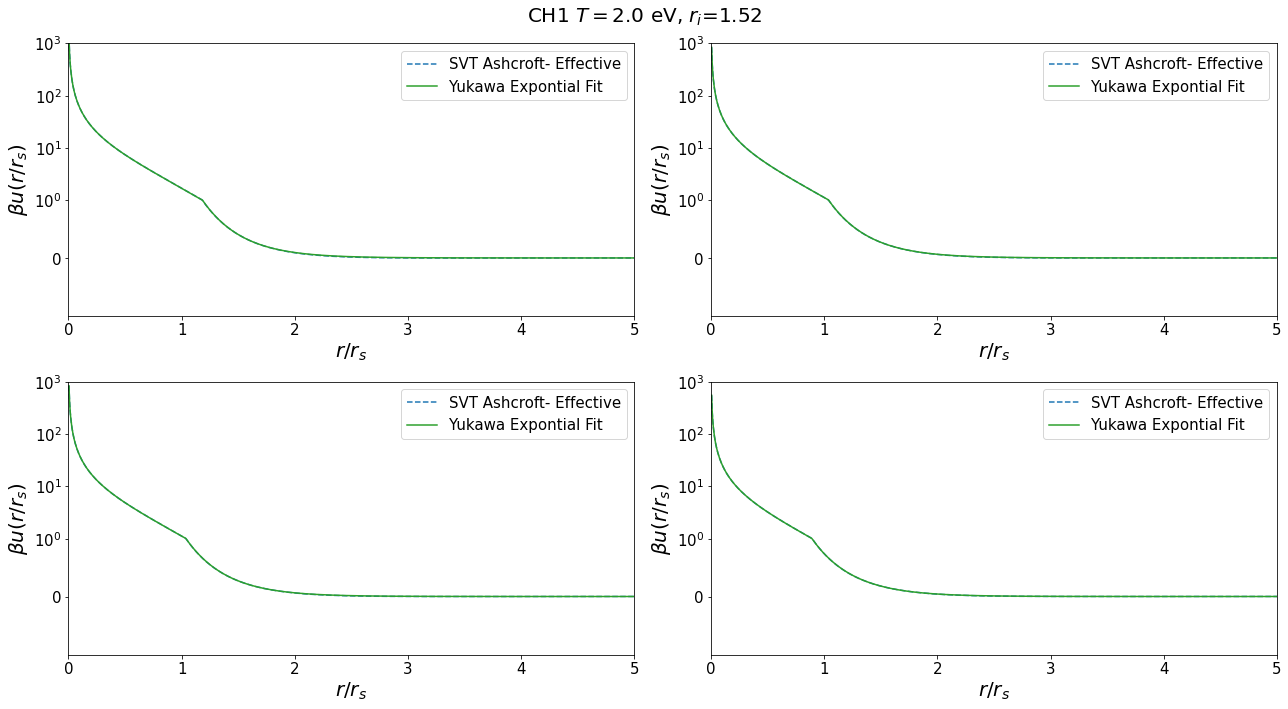

In [131]:
fig, axs = plt.subplots(2,2,figsize=(18,10),facecolor='w')
fig.suptitle(r"CH1 $T=${0:.1f} eV, $r_i$={1:.2f}".format(Te/eV,CH1qsp1.ri), fontsize=20)

yukawa_matrix = (CH1.Gamma[:,:,np.newaxis]/CH1.r_array * np.exp(-CH1.r_array*CH1qsp1.get_κ())[np.newaxis,np.newaxis,:] ) [:-1,:-1]
coulomb_matrix = (CH1.Gamma[:,:,np.newaxis]/CH1.r_array) [:-1,:-1]
for i in range(CH1.Neff_species):
            for j in range(CH1.Neff_species):
                axs[i,j].plot(CH1.r_array, CH1SVT_ps.βueff_r_matrix[i,j],'--',color=colors[0], label='SVT Ashcroft- Effective')
#                 axs[i,j].plot(CH1.r_array, SVTy_fit_matrix[i][j].y_fit,color=colors[1],linestyle='-', label="Yukawa Fit")
                axs[i,j].plot(CH1.r_array, SVTyp_fit_matrix[i][j].y_fit,color=colors[2],linestyle='-', label="Yukawa Expontial Fit")
                
#                 axs[i,j].plot(CH1.r_array, CH1SVT_ps.βueff_r_matrix[i,j]/SVTygen_fit_matrix[i][j].y_fit,'--',color=colors[0], label='SVT Ashcroft- Effective')
                
#                 axs[i,j].plot(CH1.r_array, yukawa_matrix[i,j],'r--', label="Yukawa")
#                 axs[i,j].plot(CH1.r_array, coulomb_matrix[i,j],'r-', label="Coulomb")
                
#                 axs[i,j].plot(CH1SVT.r_array, CH1SVT.h_r_matrix[i,j]+1, label='SVT OZ')
#                 axs[i,j].set_title(CH1.name_matrix[i][j] + r", $\Gamma_{{ {0},{1} }}$ = {2:.2f}".format(i,j,CH1.Gamma[i][j]) ,fontsize=15)
                axs[i,j].set_ylim(-1,1e3)
                axs[i,j].tick_params(labelsize=20)
                axs[-1,j].set_xlabel(r"$r/r_s$",fontsize=20)
                axs[i,j].set_ylabel(r'$\beta u(r/r_s)$',fontsize=20)
                axs[i,j].set_xlabel(r'$r/r_s$',fontsize=20)
               
                axs[i,j].set_xlim(0,5)
                axs[i,j].set_yscale('symlog',linthresh=1)
                axs[i,j].tick_params(labelsize=15)
                axs[i,j].legend(fontsize=15)
fig.tight_layout()

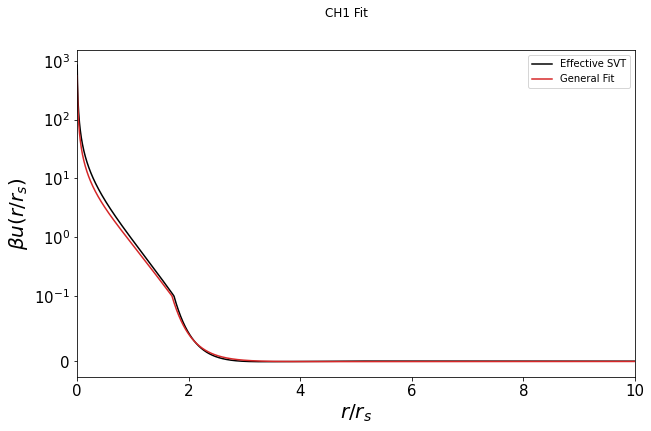

In [108]:
# fig, ax = plt.subplots(figsize=(10,6))
# fig.suptitle('CH1 Fit')

# g_data = CH1.h_r_matrix[0,0] + 1

# # ax.plot(CH1.r_array, CH1.βueff_r_matrix[0,0],'k--', label="Effective")
# # ax.plot(yukawa_fit.r, yukawa_fit.y_fit,color=colors[0], linestyle='--', label="Yukawa Fit")
# # ax.plot(yukawa_fit.r, yukawa_friedel_fit.y_fit,color=colors[1], linestyle='--', label="Yukawa Fridel Fit")
# # ax.plot(yukawa_fit.r, yfg_fit.y_fit,color=colors[2], linestyle='--', label="Yukawa Exp Guassian Fit")
# # ax.plot(yukawa_fit.r, yfpg_fit.y_fit,color=colors[3], linestyle='--', label="Yukawa Exp c Guassian Fit")

# ax.plot(CH1.r_array, CH1SVT.βueff_r_matrix[0,1],'k-', label="Effective SVT")
# # ax.plot(SVTy_fit.r, SVTy_fit.y_fit,color=colors[0], linestyle='-', label="Yukawa Fit")
# # ax.plot(SVTy_fit.r, SVTyf_fit.y_fit,color=colors[1],linestyle='-', label="Yukawa Friedel Fit")
# # ax.plot(SVTy_fit.r, SVTypg_fit.y_fit,color=colors[2],linestyle='-', label="Yukawa Exp Guassian Fit")
# ax.plot(SVTy_fit.r, SVTygen_fit.y_fit,color=colors[3],linestyle='-', label="General Fit")
# # ax.plot(SVTy_fit.r, SVTygen_fit.y_fit-SVTygen_fit.y, color=colors[3],linestyle='-', label="General Fit")

# ax.set_ylabel(r'$\beta u(r/r_s)$',fontsize=20)
# ax.set_xlabel(r'$r/r_s$',fontsize=20)
# # ax.set_ylim(-0.1,0.1)
# ax.set_yscale('symlog',linthresh=1e-1)
# ax.set_xlim(0e-2,10)
# # ax.set_xscale('log')
# ax.tick_params(labelsize=15)
# ax.legend(fontsize=10)

In [100]:
def yukawa_gen(r, a ,b ,c, d ,e, f, g, h, i):
    return  a/r*np.exp(-b*r)/(1+np.exp(c*(r-d))) + e*np.exp(-(f-r)**2/g) + h/r
SVTygen_fit.y_vals[0]

array([ 7.39145233e+00, -6.03340961e-02,  2.78971844e+00,  6.68341458e-01,
       -4.13993867e+00, -2.38448707e-01,  7.56277944e-01, -6.45229703e-03,
        1.00000000e+00])

## Copper

In [9]:
ni = 8.49e22 # per cc
Te = 1*eV 
Ti   = 1*eV 
Z, A = 29,63.55
Zstar= 1.206


copper,_ = run_hnc(ni, Te, Z, A, Zstar ,num_iterations=1e3, method='fixed', alpha=0.1)

Λee = 0.417
Λei = 0.295
Γii=14.837, Γie=-1.761, Γee=1.460 
r_i=2.667
r_e=2.506
θ  =1.25e-01
0: Err in c_r: 5.54e+00, OZ: 1.49e-01, HNC: 5.17e+00, tot: 0.44
1: Err in c_r: 5.02e+00, OZ: 1.46e-01, HNC: 3.59e+00, tot: 0.43
2: Err in c_r: 4.54e+00, OZ: 1.43e-01, HNC: 2.69e+00, tot: 0.43
3: Err in c_r: 4.11e+00, OZ: 1.40e-01, HNC: 2.14e+00, tot: 0.44
4: Err in c_r: 3.72e+00, OZ: 1.38e-01, HNC: 1.78e+00, tot: 0.44
5: Err in c_r: 3.37e+00, OZ: 1.35e-01, HNC: 1.55e+00, tot: 0.45
6: Err in c_r: 3.05e+00, OZ: 1.33e-01, HNC: 1.39e+00, tot: 0.46
7: Err in c_r: 2.76e+00, OZ: 1.30e-01, HNC: 1.28e+00, tot: 0.46
8: Err in c_r: 2.50e+00, OZ: 1.28e-01, HNC: 1.20e+00, tot: 0.47
9: Err in c_r: 2.26e+00, OZ: 1.26e-01, HNC: 1.16e+00, tot: 0.48
10: Err in c_r: 2.05e+00, OZ: 1.24e-01, HNC: 1.13e+00, tot: 0.49
11: Err in c_r: 1.85e+00, OZ: 1.22e-01, HNC: 1.13e+00, tot: 0.50
12: Err in c_r: 1.68e+00, OZ: 1.20e-01, HNC: 1.13e+00, tot: 0.52
13: Err in c_r: 1.52e+00, OZ: 1.18e-01, HNC: 1.15e+00, tot: 0.53
14: Err 

135: Err in c_r: 3.75e-03, OZ: 1.27e-02, HNC: 2.68e-01, tot: 1.49
136: Err in c_r: 3.66e-03, OZ: 1.24e-02, HNC: 2.62e-01, tot: 1.49
137: Err in c_r: 3.58e-03, OZ: 1.22e-02, HNC: 2.55e-01, tot: 1.49
138: Err in c_r: 3.49e-03, OZ: 1.19e-02, HNC: 2.49e-01, tot: 1.49
139: Err in c_r: 3.41e-03, OZ: 1.17e-02, HNC: 2.43e-01, tot: 1.49
140: Err in c_r: 3.33e-03, OZ: 1.14e-02, HNC: 2.37e-01, tot: 1.50
141: Err in c_r: 3.25e-03, OZ: 1.12e-02, HNC: 2.31e-01, tot: 1.50
142: Err in c_r: 3.18e-03, OZ: 1.09e-02, HNC: 2.25e-01, tot: 1.50
143: Err in c_r: 3.11e-03, OZ: 1.07e-02, HNC: 2.20e-01, tot: 1.50
144: Err in c_r: 3.03e-03, OZ: 1.05e-02, HNC: 2.14e-01, tot: 1.50
145: Err in c_r: 2.96e-03, OZ: 1.03e-02, HNC: 2.09e-01, tot: 1.50
146: Err in c_r: 2.89e-03, OZ: 1.00e-02, HNC: 2.04e-01, tot: 1.50
147: Err in c_r: 2.83e-03, OZ: 9.82e-03, HNC: 1.99e-01, tot: 1.50
148: Err in c_r: 2.76e-03, OZ: 9.61e-03, HNC: 1.94e-01, tot: 1.50
149: Err in c_r: 2.70e-03, OZ: 9.41e-03, HNC: 1.89e-01, tot: 1.51
150: Err i

274: Err in c_r: 1.61e-04, OZ: 6.05e-04, HNC: 1.08e-02, tot: 1.55
275: Err in c_r: 1.57e-04, OZ: 5.92e-04, HNC: 1.06e-02, tot: 1.55
276: Err in c_r: 1.54e-04, OZ: 5.79e-04, HNC: 1.03e-02, tot: 1.55
277: Err in c_r: 1.50e-04, OZ: 5.66e-04, HNC: 1.01e-02, tot: 1.55
278: Err in c_r: 1.47e-04, OZ: 5.54e-04, HNC: 9.88e-03, tot: 1.55
279: Err in c_r: 1.44e-04, OZ: 5.42e-04, HNC: 9.67e-03, tot: 1.55
280: Err in c_r: 1.41e-04, OZ: 5.30e-04, HNC: 9.45e-03, tot: 1.55
281: Err in c_r: 1.38e-04, OZ: 5.18e-04, HNC: 9.24e-03, tot: 1.55
282: Err in c_r: 1.35e-04, OZ: 5.07e-04, HNC: 9.04e-03, tot: 1.55
283: Err in c_r: 1.32e-04, OZ: 4.96e-04, HNC: 8.84e-03, tot: 1.55
284: Err in c_r: 1.29e-04, OZ: 4.85e-04, HNC: 8.65e-03, tot: 1.55
285: Err in c_r: 1.26e-04, OZ: 4.74e-04, HNC: 8.46e-03, tot: 1.55
286: Err in c_r: 1.23e-04, OZ: 4.64e-04, HNC: 8.27e-03, tot: 1.55
287: Err in c_r: 1.20e-04, OZ: 4.54e-04, HNC: 8.09e-03, tot: 1.55
288: Err in c_r: 1.18e-04, OZ: 4.44e-04, HNC: 7.91e-03, tot: 1.55
289: Err i

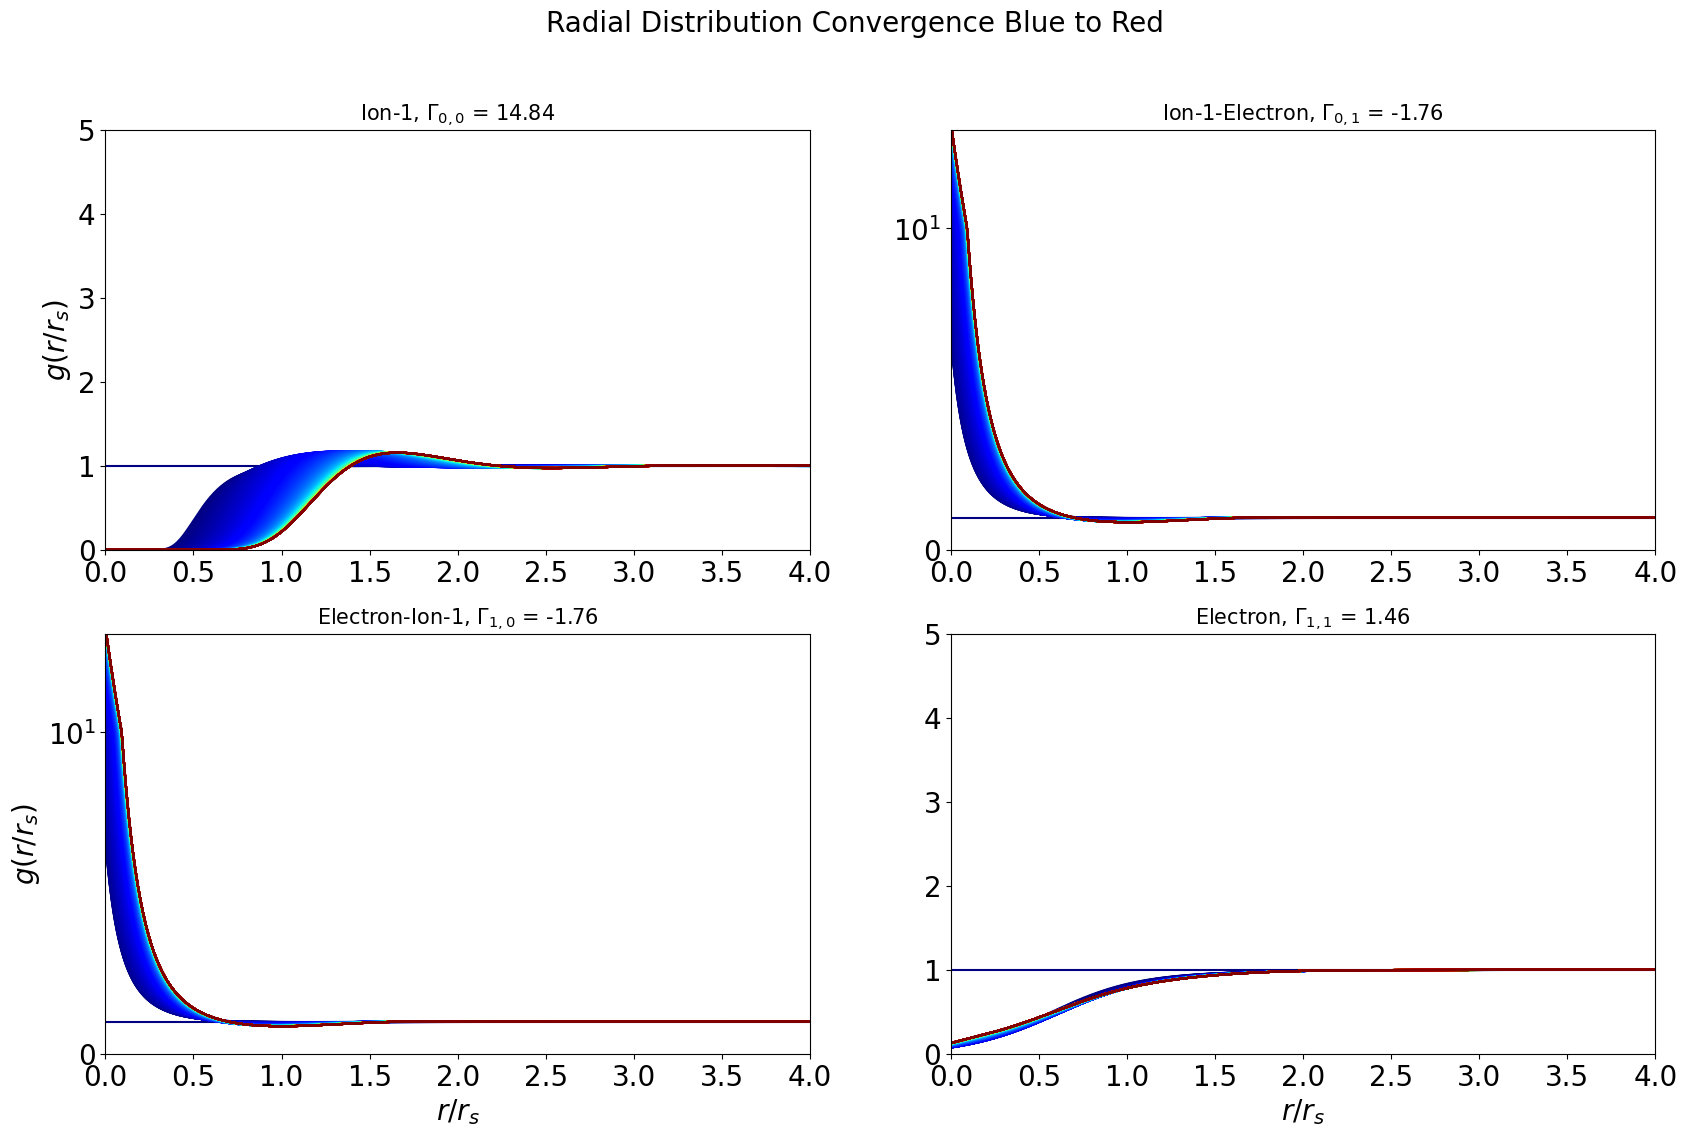

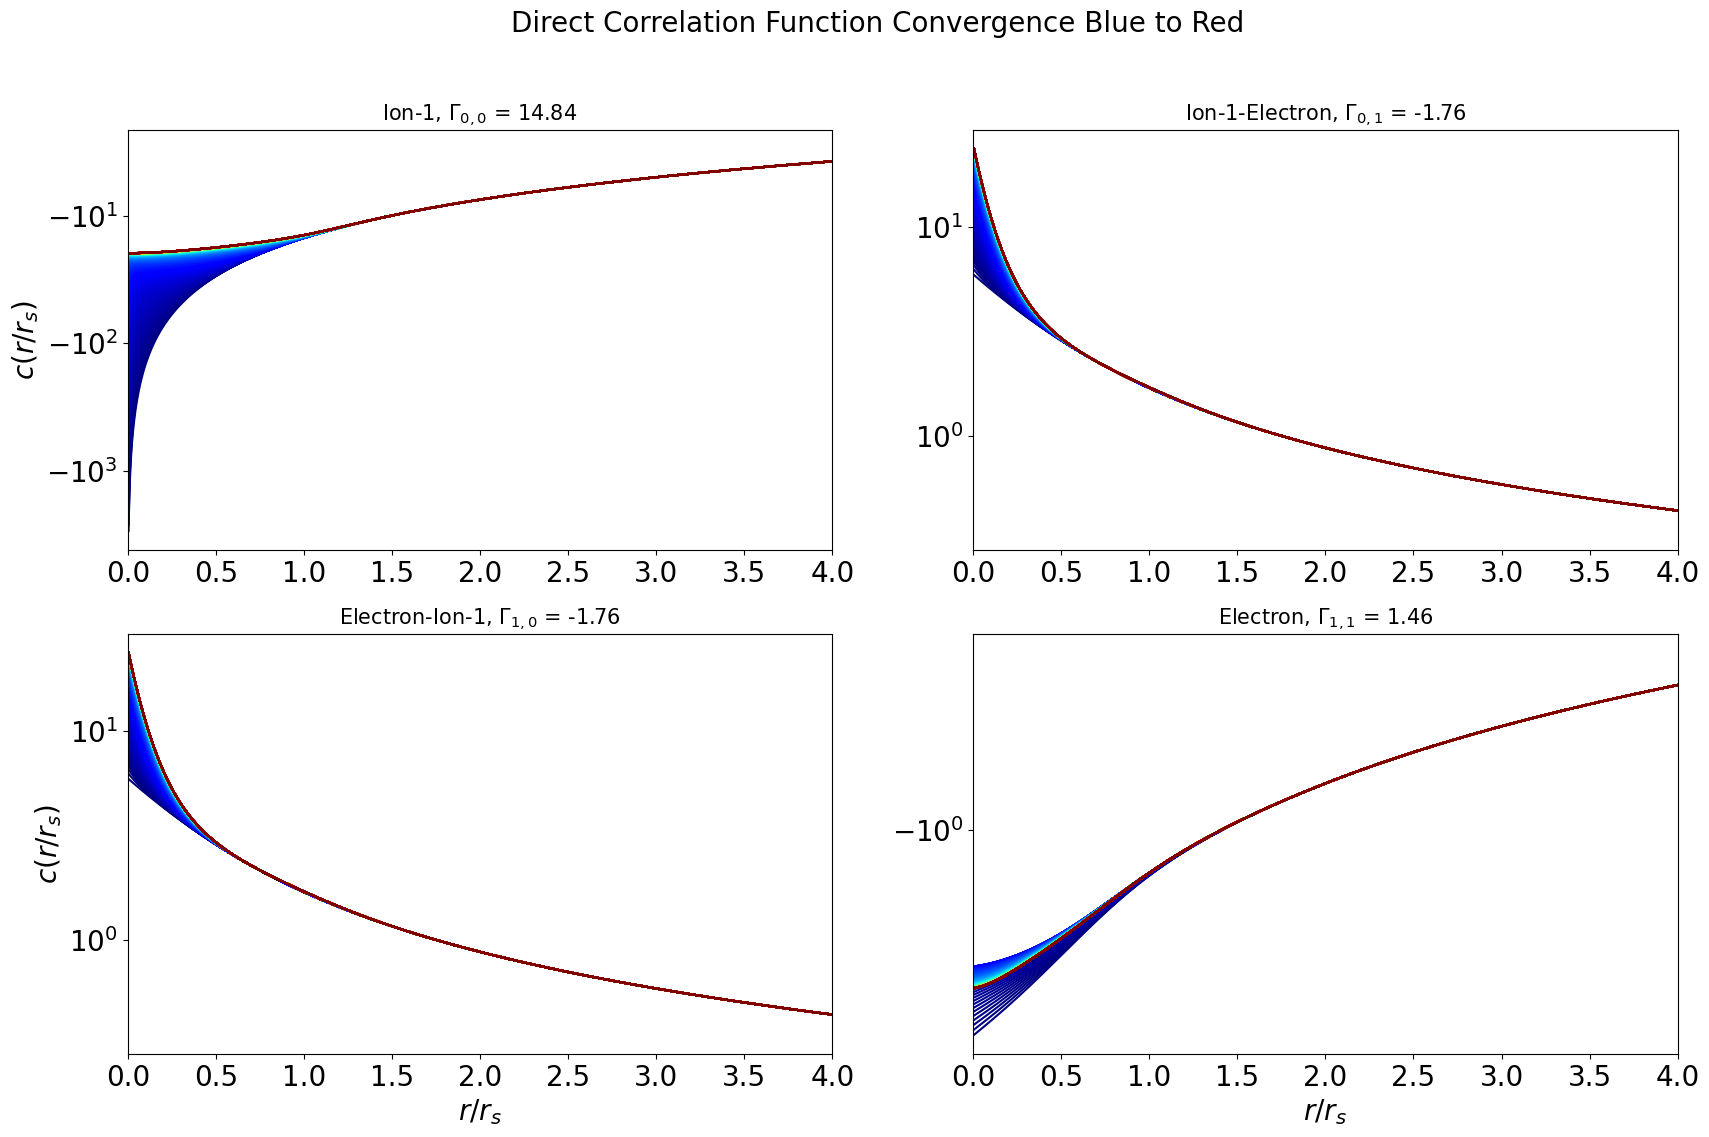

In [10]:
copper.plot_species_convergence_g(n_slices= int(len(copper.h_list)/1)  )
copper.plot_species_convergence_c(n_slices= int(len(copper.h_list)/1)  )

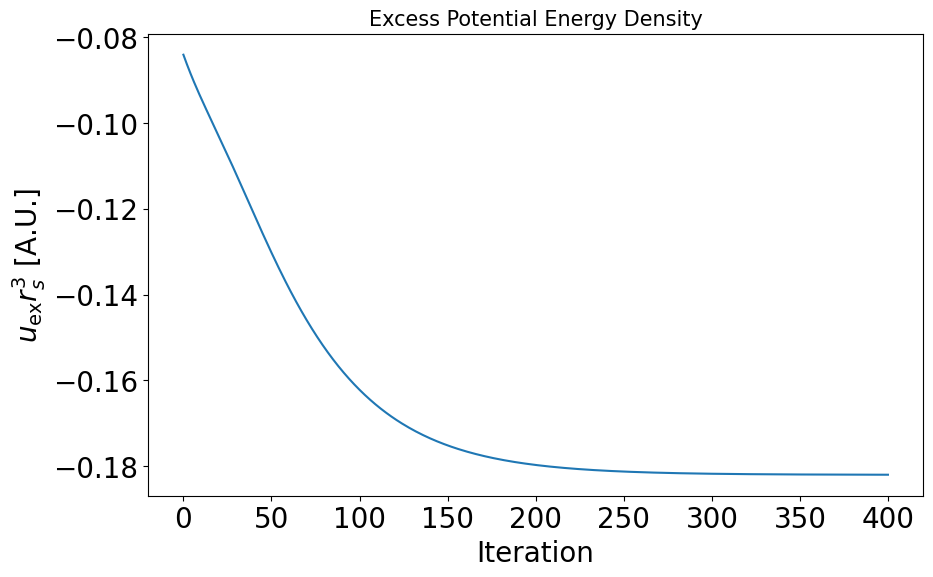

In [11]:
copper.plot_convergence_uex()

In [26]:
copper_one_species,_ = run_hnc_one_species(ni, Te, Z, A, Zstar )

Λee = 0.417
Λei = 0.295
Γii=14.837, Γie=-1.761, Γee=1.460 
r_i=2.667
r_e=2.506
θ  =1.25e-01
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.00313886] True Optimization terminated successfully.
0: Err in c_r: 5.56e+01, OZ: 1.54e-01, HNC: 1.60e-02
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
1: Err in c_r: 2.90e+01, OZ: 1.45e-01, HNC: 1.15e-02
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
2: Err in c_r: 1.52e+01, OZ: 1.34e-01, HNC: 9.94e-03
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
3: Err in c_r: 8.05e+00, OZ: 1.25e-01, HNC: 9.62e-03
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
4: Err in c_r: 4.34e+00, OZ: 1.17e-01, HNC: 9.65e-03
 HNC min: [0.5] True Optimization terminated succe

 OZ min:  [0.] True Optimization terminated successfully.
52: Err in c_r: 2.06e-03, OZ: 9.59e-04, HNC: 9.72e-05
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
53: Err in c_r: 1.85e-03, OZ: 8.61e-04, HNC: 8.72e-05
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
54: Err in c_r: 1.66e-03, OZ: 7.72e-04, HNC: 7.82e-05
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
55: Err in c_r: 1.49e-03, OZ: 6.93e-04, HNC: 7.02e-05
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
56: Err in c_r: 1.34e-03, OZ: 6.22e-04, HNC: 6.29e-05
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
57: Err in c_r: 1.20e-03, OZ: 5.58e-04, HNC: 5.65e-05
 HNC min: [0.5] True Optimization

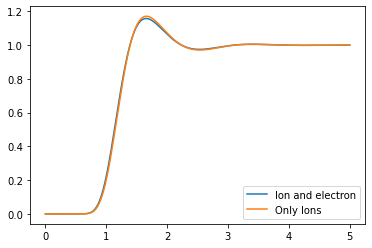

In [27]:
fig, ax = plt.subplots()

ax.plot(copper.r_array, copper.h_r_matrix[0,0]+1, label='Ion and electron')
ax.plot(copper.r_array, copper_one_species.h_r_matrix[0,0]+1, label="Only Ions")
ax.legend()



## Hydrogen

In [15]:
ni = 5.98e23 # per cc
Te = 2*eV 
Ti   = 2*eV 
Z, A = 1,1
Zstar= 1
hydrogen, _ = run_hnc(ni, Te, Z, A, Zstar ,method='fixed',alpha=0.1)

Λee = 0.465
Λei = 0.329
Γii=9.778, Γie=-0.944, Γee=0.944 
r_i=1.391
r_e=1.391
θ  =7.73e-02
0: Err in c_r: 3.70e+00, OZ: 1.25e-01, HNC: 1.26e-01, tot: 0.25
1: Err in c_r: 3.34e+00, OZ: 1.22e-01, HNC: 1.13e-01, tot: 0.26
2: Err in c_r: 3.02e+00, OZ: 1.20e-01, HNC: 1.03e-01, tot: 0.26
3: Err in c_r: 2.73e+00, OZ: 1.17e-01, HNC: 9.42e-02, tot: 0.26
4: Err in c_r: 2.47e+00, OZ: 1.14e-01, HNC: 8.73e-02, tot: 0.27
5: Err in c_r: 2.24e+00, OZ: 1.11e-01, HNC: 8.17e-02, tot: 0.27
6: Err in c_r: 2.02e+00, OZ: 1.09e-01, HNC: 7.70e-02, tot: 0.27
7: Err in c_r: 1.83e+00, OZ: 1.07e-01, HNC: 7.32e-02, tot: 0.28
8: Err in c_r: 1.65e+00, OZ: 1.04e-01, HNC: 7.00e-02, tot: 0.28
9: Err in c_r: 1.49e+00, OZ: 1.02e-01, HNC: 6.74e-02, tot: 0.28
10: Err in c_r: 1.35e+00, OZ: 9.98e-02, HNC: 6.52e-02, tot: 0.28
11: Err in c_r: 1.22e+00, OZ: 9.77e-02, HNC: 6.35e-02, tot: 0.29
12: Err in c_r: 1.10e+00, OZ: 9.56e-02, HNC: 6.21e-02, tot: 0.29
13: Err in c_r: 9.99e-01, OZ: 9.36e-02, HNC: 6.10e-02, tot: 0.29
14: Err i

135: Err in c_r: 1.25e-03, OZ: 4.69e-03, HNC: 4.09e-03, tot: 0.43
136: Err in c_r: 1.21e-03, OZ: 4.56e-03, HNC: 3.98e-03, tot: 0.43
137: Err in c_r: 1.18e-03, OZ: 4.44e-03, HNC: 3.87e-03, tot: 0.43
138: Err in c_r: 1.14e-03, OZ: 4.32e-03, HNC: 3.76e-03, tot: 0.43
139: Err in c_r: 1.11e-03, OZ: 4.20e-03, HNC: 3.66e-03, tot: 0.43
140: Err in c_r: 1.08e-03, OZ: 4.09e-03, HNC: 3.56e-03, tot: 0.43
141: Err in c_r: 1.05e-03, OZ: 3.98e-03, HNC: 3.46e-03, tot: 0.43
142: Err in c_r: 1.02e-03, OZ: 3.87e-03, HNC: 3.36e-03, tot: 0.43
143: Err in c_r: 9.92e-04, OZ: 3.77e-03, HNC: 3.27e-03, tot: 0.43
144: Err in c_r: 9.65e-04, OZ: 3.67e-03, HNC: 3.18e-03, tot: 0.43
145: Err in c_r: 9.38e-04, OZ: 3.57e-03, HNC: 3.09e-03, tot: 0.43
146: Err in c_r: 9.11e-04, OZ: 3.47e-03, HNC: 3.01e-03, tot: 0.43
147: Err in c_r: 8.86e-04, OZ: 3.38e-03, HNC: 2.93e-03, tot: 0.43
148: Err in c_r: 8.61e-04, OZ: 3.29e-03, HNC: 2.85e-03, tot: 0.43
149: Err in c_r: 8.37e-04, OZ: 3.20e-03, HNC: 2.77e-03, tot: 0.43
150: Err i

275: Err in c_r: 2.51e-05, OZ: 9.91e-05, HNC: 8.40e-05, tot: 0.43
276: Err in c_r: 2.44e-05, OZ: 9.64e-05, HNC: 8.17e-05, tot: 0.43
277: Err in c_r: 2.38e-05, OZ: 9.38e-05, HNC: 7.95e-05, tot: 0.43
278: Err in c_r: 2.31e-05, OZ: 9.12e-05, HNC: 7.73e-05, tot: 0.43
279: Err in c_r: 2.25e-05, OZ: 8.87e-05, HNC: 7.52e-05, tot: 0.43
280: Err in c_r: 2.19e-05, OZ: 8.63e-05, HNC: 7.32e-05, tot: 0.43
281: Err in c_r: 2.13e-05, OZ: 8.39e-05, HNC: 7.12e-05, tot: 0.43
282: Err in c_r: 2.07e-05, OZ: 8.17e-05, HNC: 6.92e-05, tot: 0.43
283: Err in c_r: 2.01e-05, OZ: 7.94e-05, HNC: 6.73e-05, tot: 0.43
284: Err in c_r: 1.96e-05, OZ: 7.73e-05, HNC: 6.55e-05, tot: 0.43
285: Err in c_r: 1.90e-05, OZ: 7.52e-05, HNC: 6.37e-05, tot: 0.43
286: Err in c_r: 1.85e-05, OZ: 7.31e-05, HNC: 6.20e-05, tot: 0.43
287: Err in c_r: 1.80e-05, OZ: 7.11e-05, HNC: 6.03e-05, tot: 0.43
288: Err in c_r: 1.75e-05, OZ: 6.92e-05, HNC: 5.86e-05, tot: 0.43
289: Err in c_r: 1.70e-05, OZ: 6.73e-05, HNC: 5.70e-05, tot: 0.43
290: Err i

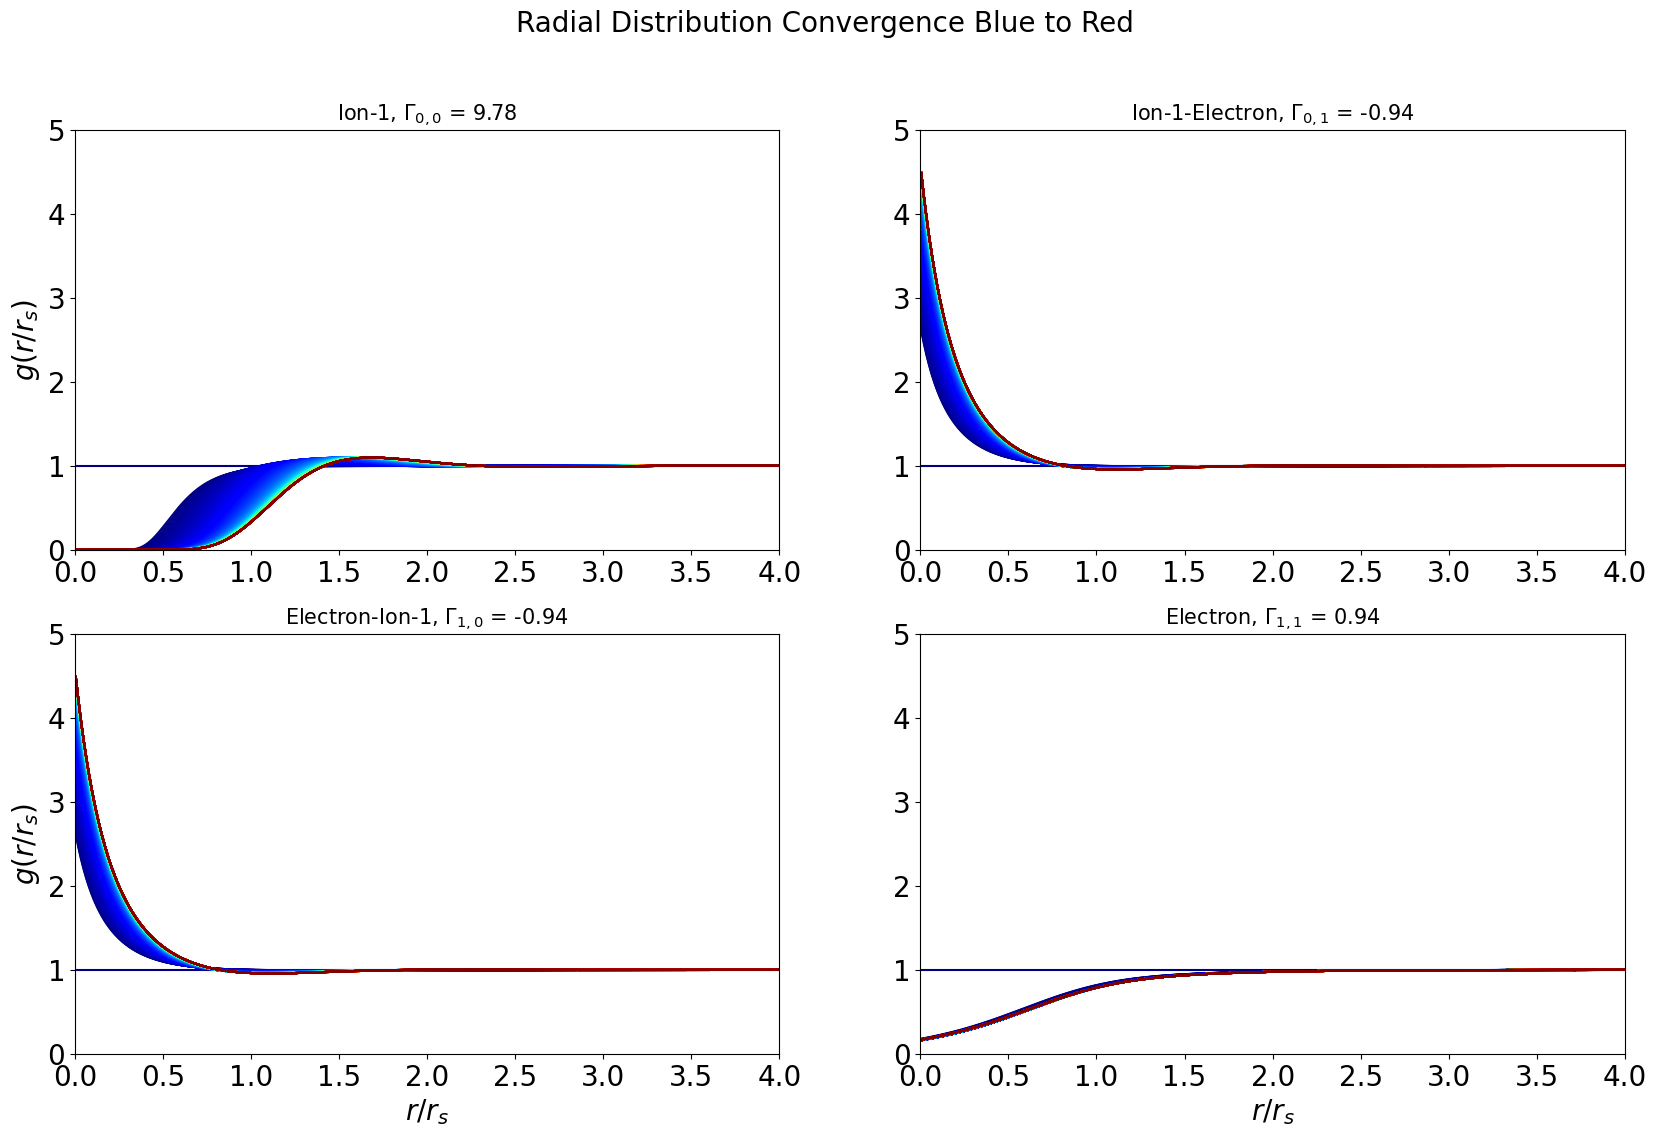

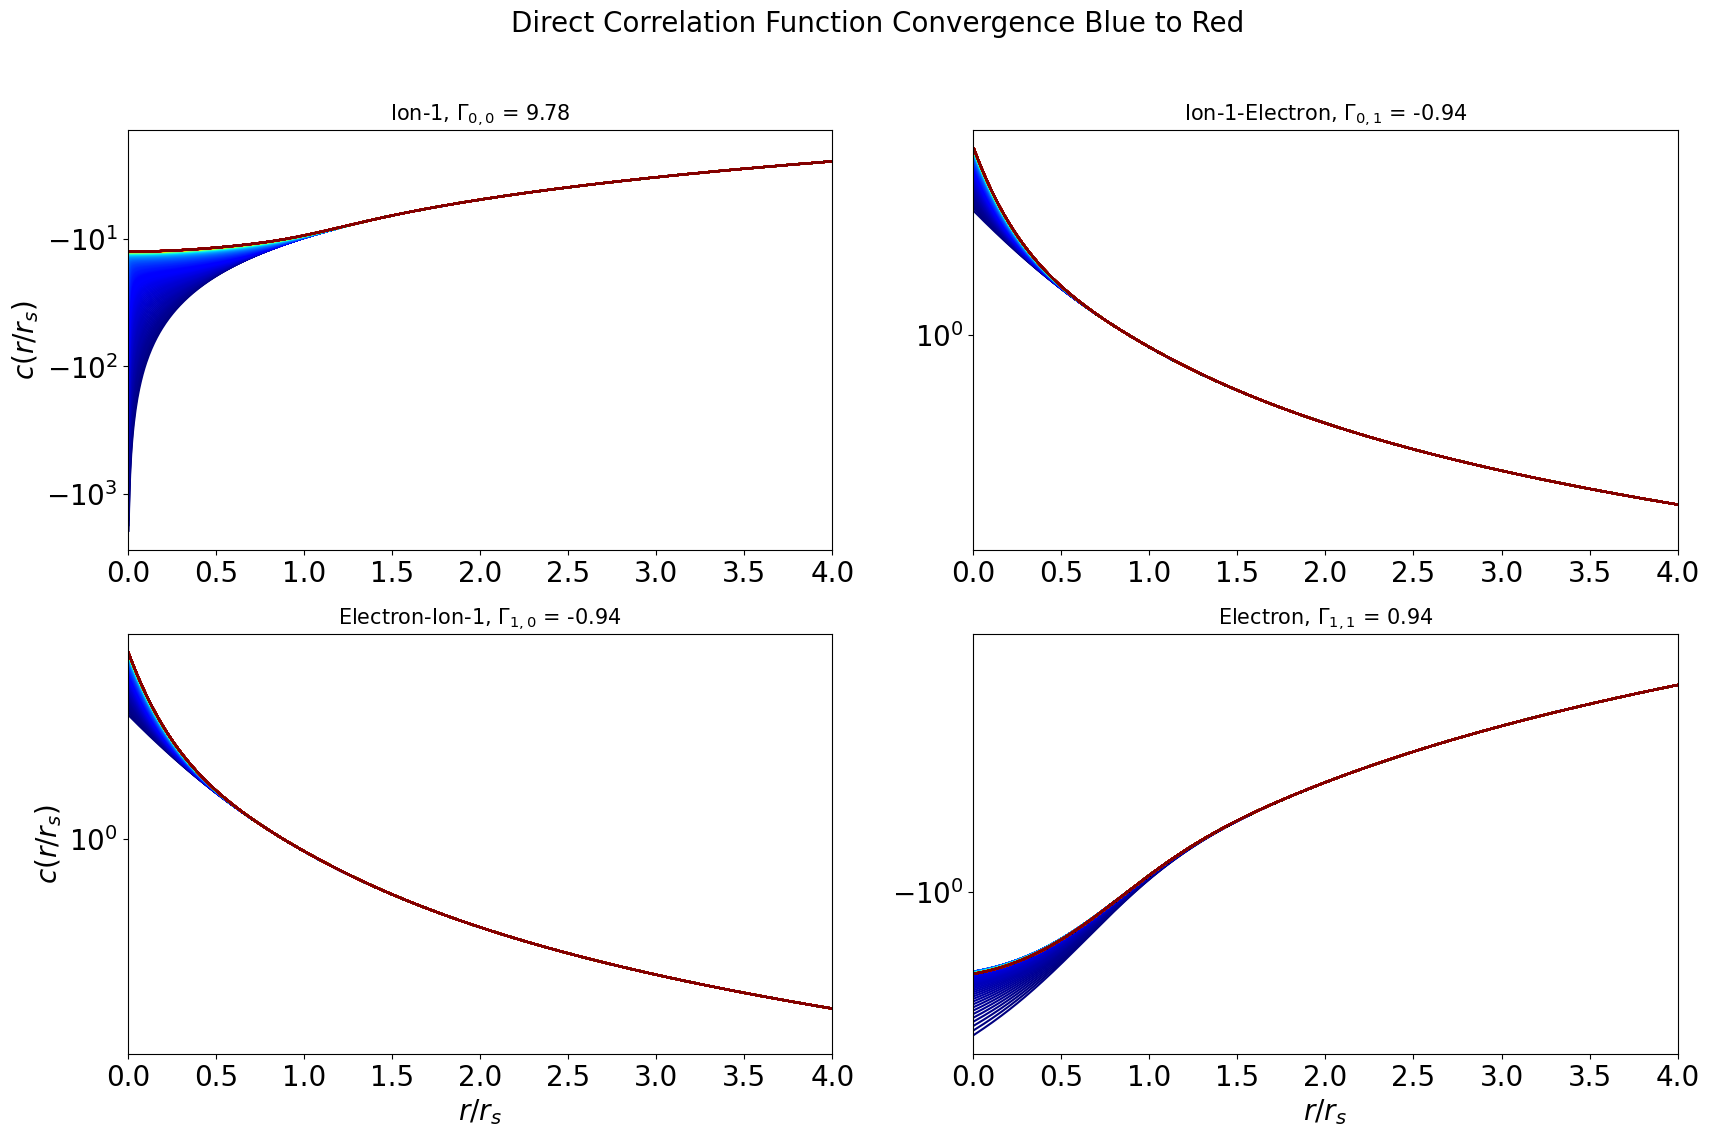

In [16]:
hydrogen.plot_species_convergence_g(n_slices= int(len(hydrogen.h_list)/1)  )
hydrogen.plot_species_convergence_c(n_slices= int(len(hydrogen.h_list)/1)  )

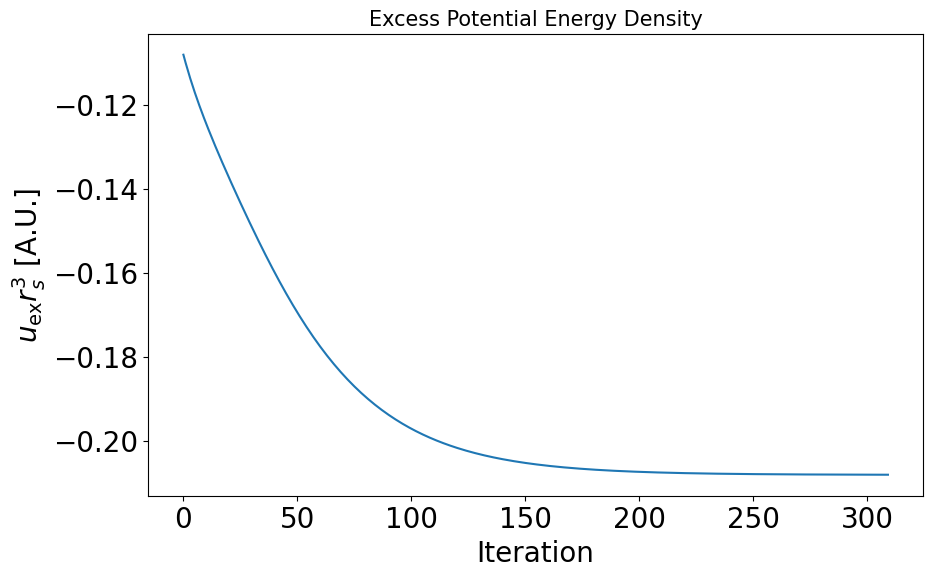

In [19]:
hydrogen.plot_convergence_uex()

In [23]:
hydrogen_one_species,_ = run_hnc_one_ion(ni, Te, Z, A, Zstar , method='fixed',alpha=0.1)

Λee = 0.465
Λei = 0.329
Γii=9.778, Γie=-0.944, Γee=0.944 
r_i=1.391
r_e=1.391
θ  =7.73e-02
0: Err in c_r: 7.39e+00, OZ: 2.50e-01, HNC: 5.71e-02, tot: 0.33
1: Err in c_r: 6.69e+00, OZ: 2.44e-01, HNC: 4.51e-02, tot: 0.33
2: Err in c_r: 6.05e+00, OZ: 2.38e-01, HNC: 3.83e-02, tot: 0.34
3: Err in c_r: 5.47e+00, OZ: 2.33e-01, HNC: 3.38e-02, tot: 0.34
4: Err in c_r: 4.94e+00, OZ: 2.28e-01, HNC: 3.05e-02, tot: 0.34
5: Err in c_r: 4.47e+00, OZ: 2.23e-01, HNC: 2.81e-02, tot: 0.35
6: Err in c_r: 4.04e+00, OZ: 2.18e-01, HNC: 2.62e-02, tot: 0.35
7: Err in c_r: 3.66e+00, OZ: 2.13e-01, HNC: 2.47e-02, tot: 0.36
8: Err in c_r: 3.31e+00, OZ: 2.08e-01, HNC: 2.34e-02, tot: 0.36
9: Err in c_r: 2.99e+00, OZ: 2.04e-01, HNC: 2.24e-02, tot: 0.36
10: Err in c_r: 2.70e+00, OZ: 2.00e-01, HNC: 2.16e-02, tot: 0.37
11: Err in c_r: 2.44e+00, OZ: 1.96e-01, HNC: 2.09e-02, tot: 0.37
12: Err in c_r: 2.21e+00, OZ: 1.91e-01, HNC: 2.03e-02, tot: 0.37
13: Err in c_r: 2.00e+00, OZ: 1.87e-01, HNC: 1.98e-02, tot: 0.38
14: Err i

167: Err in c_r: 1.06e-03, OZ: 4.15e-03, HNC: 5.58e-04, tot: 0.47
168: Err in c_r: 1.04e-03, OZ: 4.04e-03, HNC: 5.43e-04, tot: 0.47
169: Err in c_r: 1.01e-03, OZ: 3.93e-03, HNC: 5.28e-04, tot: 0.47
170: Err in c_r: 9.80e-04, OZ: 3.83e-03, HNC: 5.14e-04, tot: 0.47
171: Err in c_r: 9.54e-04, OZ: 3.73e-03, HNC: 5.01e-04, tot: 0.47
172: Err in c_r: 9.28e-04, OZ: 3.63e-03, HNC: 4.87e-04, tot: 0.47
173: Err in c_r: 9.03e-04, OZ: 3.53e-03, HNC: 4.74e-04, tot: 0.47
174: Err in c_r: 8.78e-04, OZ: 3.44e-03, HNC: 4.62e-04, tot: 0.47
175: Err in c_r: 8.54e-04, OZ: 3.35e-03, HNC: 4.49e-04, tot: 0.47
176: Err in c_r: 8.31e-04, OZ: 3.26e-03, HNC: 4.37e-04, tot: 0.47
177: Err in c_r: 8.09e-04, OZ: 3.17e-03, HNC: 4.26e-04, tot: 0.47
178: Err in c_r: 7.87e-04, OZ: 3.08e-03, HNC: 4.14e-04, tot: 0.47
179: Err in c_r: 7.65e-04, OZ: 3.00e-03, HNC: 4.03e-04, tot: 0.47
180: Err in c_r: 7.45e-04, OZ: 2.92e-03, HNC: 3.93e-04, tot: 0.47
181: Err in c_r: 7.24e-04, OZ: 2.84e-03, HNC: 3.82e-04, tot: 0.47
182: Err i

330: Err in c_r: 1.25e-05, OZ: 4.97e-05, HNC: 6.68e-06, tot: 0.47
331: Err in c_r: 1.22e-05, OZ: 4.84e-05, HNC: 6.50e-06, tot: 0.47
332: Err in c_r: 1.18e-05, OZ: 4.71e-05, HNC: 6.33e-06, tot: 0.47
333: Err in c_r: 1.15e-05, OZ: 4.58e-05, HNC: 6.16e-06, tot: 0.47
334: Err in c_r: 1.12e-05, OZ: 4.46e-05, HNC: 6.00e-06, tot: 0.47
335: Err in c_r: 1.09e-05, OZ: 4.34e-05, HNC: 5.83e-06, tot: 0.47
336: Err in c_r: 1.06e-05, OZ: 4.22e-05, HNC: 5.68e-06, tot: 0.47
337: Err in c_r: 1.03e-05, OZ: 4.11e-05, HNC: 5.53e-06, tot: 0.47
338: Err in c_r: 1.00e-05, OZ: 4.00e-05, HNC: 5.38e-06, tot: 0.47
339: Err in c_r: 9.78e-06, OZ: 3.89e-05, HNC: 5.23e-06, tot: 0.47


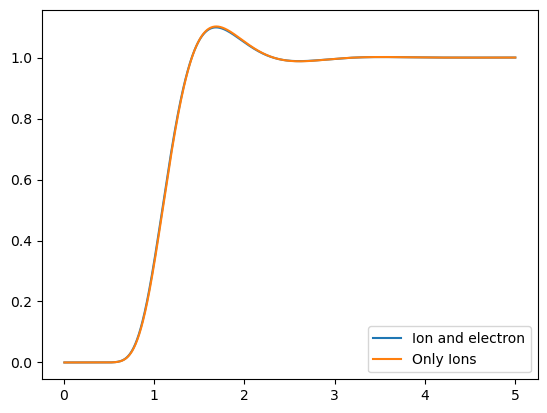

In [24]:
fig, ax = plt.subplots()

ax.plot(hydrogen.r_array, hydrogen.h_r_matrix[0,0]+1, label='Ion and electron')
ax.plot(hydrogen.r_array, hydrogen_one_species.h_r_matrix[0,0]+1, label="Only Ions")
ax.legend()



## Aluminum

In [33]:
ni = 6.03e22 # per cc, rs=3
Te = 0.5*eV 
Ti   = 0.5*eV 
Z, A = 13,27
Zstar= 3

In [34]:
aluminum_one_species,_ = run_hnc_one_ion(ni, Te, Z, A, Zstar , method='fixed',alpha=0.5)

Λei = 0.222
Λee = 0.314
Λei adjusted with R = 0.222
Γii=163.834, Γie=-2.780, Γee=0.927 
r_i=2.989
r_e=2.073
θ  =4.29e-02
0: Err in c_r: 3.81e+02, OZ: 3.44e-01, HNC: 7.61e-03, tot: 3.81e+02, tot: 4.27e+02
1: Err in c_r: 2.14e+02, OZ: 3.23e-01, HNC: 3.10e-03, tot: 2.14e+02, tot: 2.41e+02
2: Err in c_r: 1.20e+02, OZ: 3.08e-01, HNC: 1.00e-02, tot: 1.20e+02, tot: 1.38e+02
3: Err in c_r: 6.91e+01, OZ: 3.00e-01, HNC: 2.23e-01, tot: 6.91e+01, tot: 8.20e+01
4: Err in c_r: 4.10e+01, OZ: 3.00e-01, HNC: 1.98e+00, tot: 4.10e+01, tot: 5.12e+01
5: Err in c_r: 2.56e+01, OZ: 2.97e-01, HNC: 2.85e+00, tot: 2.56e+01, tot: 3.40e+01
6: Err in c_r: 1.70e+01, OZ: 2.97e-01, HNC: 4.80e+00, tot: 1.70e+01, tot: 2.43e+01
7: Err in c_r: 1.21e+01, OZ: 2.94e-01, HNC: 4.57e+00, tot: 1.21e+01, tot: 1.85e+01
8: Err in c_r: 9.24e+00, OZ: 2.93e-01, HNC: 5.24e+00, tot: 9.24e+00, tot: 1.48e+01
9: Err in c_r: 7.42e+00, OZ: 2.89e-01, HNC: 3.82e+00, tot: 7.42e+00, tot: 1.24e+01
10: Err in c_r: 6.21e+00, OZ: 2.88e-01, HNC: 3.63

98: Err in c_r: 1.80e-01, OZ: 9.50e-02, HNC: 6.02e-03, tot: 1.80e-01, tot: 3.53e-01
99: Err in c_r: 1.76e-01, OZ: 9.37e-02, HNC: 5.85e-03, tot: 1.76e-01, tot: 3.46e-01
100: Err in c_r: 1.73e-01, OZ: 9.24e-02, HNC: 5.70e-03, tot: 1.73e-01, tot: 3.39e-01
101: Err in c_r: 1.69e-01, OZ: 9.11e-02, HNC: 5.54e-03, tot: 1.69e-01, tot: 3.32e-01
102: Err in c_r: 1.66e-01, OZ: 8.99e-02, HNC: 5.40e-03, tot: 1.66e-01, tot: 3.25e-01
103: Err in c_r: 1.63e-01, OZ: 8.86e-02, HNC: 5.26e-03, tot: 1.63e-01, tot: 3.19e-01
104: Err in c_r: 1.59e-01, OZ: 8.74e-02, HNC: 5.12e-03, tot: 1.59e-01, tot: 3.12e-01
105: Err in c_r: 1.56e-01, OZ: 8.62e-02, HNC: 4.99e-03, tot: 1.56e-01, tot: 3.06e-01
106: Err in c_r: 1.53e-01, OZ: 8.50e-02, HNC: 4.86e-03, tot: 1.53e-01, tot: 3.00e-01
107: Err in c_r: 1.50e-01, OZ: 8.38e-02, HNC: 4.74e-03, tot: 1.50e-01, tot: 2.94e-01
108: Err in c_r: 1.47e-01, OZ: 8.26e-02, HNC: 4.62e-03, tot: 1.47e-01, tot: 2.89e-01
109: Err in c_r: 1.44e-01, OZ: 8.15e-02, HNC: 4.50e-03, tot: 1.44e-

195: Err in c_r: 3.16e-02, OZ: 2.29e-02, HNC: 7.86e-04, tot: 3.16e-02, tot: 6.21e-02
196: Err in c_r: 3.11e-02, OZ: 2.25e-02, HNC: 7.73e-04, tot: 3.11e-02, tot: 6.11e-02
197: Err in c_r: 3.06e-02, OZ: 2.22e-02, HNC: 7.59e-04, tot: 3.06e-02, tot: 6.01e-02
198: Err in c_r: 3.01e-02, OZ: 2.19e-02, HNC: 7.46e-04, tot: 3.01e-02, tot: 5.91e-02
199: Err in c_r: 2.96e-02, OZ: 2.15e-02, HNC: 7.33e-04, tot: 2.96e-02, tot: 5.82e-02
200: Err in c_r: 2.91e-02, OZ: 2.12e-02, HNC: 7.20e-04, tot: 2.91e-02, tot: 5.72e-02
201: Err in c_r: 2.86e-02, OZ: 2.09e-02, HNC: 7.08e-04, tot: 2.86e-02, tot: 5.63e-02
202: Err in c_r: 2.81e-02, OZ: 2.06e-02, HNC: 6.96e-04, tot: 2.81e-02, tot: 5.54e-02
203: Err in c_r: 2.77e-02, OZ: 2.03e-02, HNC: 6.84e-04, tot: 2.77e-02, tot: 5.45e-02
204: Err in c_r: 2.72e-02, OZ: 2.00e-02, HNC: 6.72e-04, tot: 2.72e-02, tot: 5.36e-02
205: Err in c_r: 2.68e-02, OZ: 1.96e-02, HNC: 6.60e-04, tot: 2.68e-02, tot: 5.27e-02
206: Err in c_r: 2.64e-02, OZ: 1.94e-02, HNC: 6.49e-04, tot: 2.64

294: Err in c_r: 6.45e-03, OZ: 4.99e-03, HNC: 1.52e-04, tot: 6.45e-03, tot: 1.27e-02
295: Err in c_r: 6.35e-03, OZ: 4.91e-03, HNC: 1.50e-04, tot: 6.35e-03, tot: 1.25e-02
296: Err in c_r: 6.25e-03, OZ: 4.83e-03, HNC: 1.47e-04, tot: 6.25e-03, tot: 1.23e-02
297: Err in c_r: 6.15e-03, OZ: 4.76e-03, HNC: 1.45e-04, tot: 6.15e-03, tot: 1.21e-02
298: Err in c_r: 6.06e-03, OZ: 4.69e-03, HNC: 1.43e-04, tot: 6.06e-03, tot: 1.19e-02
299: Err in c_r: 5.96e-03, OZ: 4.61e-03, HNC: 1.40e-04, tot: 5.96e-03, tot: 1.17e-02
300: Err in c_r: 5.87e-03, OZ: 4.54e-03, HNC: 1.38e-04, tot: 5.87e-03, tot: 1.16e-02
301: Err in c_r: 5.78e-03, OZ: 4.47e-03, HNC: 1.36e-04, tot: 5.78e-03, tot: 1.14e-02
302: Err in c_r: 5.69e-03, OZ: 4.40e-03, HNC: 1.34e-04, tot: 5.69e-03, tot: 1.12e-02
303: Err in c_r: 5.60e-03, OZ: 4.34e-03, HNC: 1.32e-04, tot: 5.60e-03, tot: 1.10e-02
304: Err in c_r: 5.51e-03, OZ: 4.27e-03, HNC: 1.30e-04, tot: 5.51e-03, tot: 1.09e-02
305: Err in c_r: 5.43e-03, OZ: 4.20e-03, HNC: 1.28e-04, tot: 5.43

392: Err in c_r: 1.39e-03, OZ: 1.09e-03, HNC: 3.23e-05, tot: 1.39e-03, tot: 2.73e-03
393: Err in c_r: 1.37e-03, OZ: 1.07e-03, HNC: 3.18e-05, tot: 1.37e-03, tot: 2.69e-03
394: Err in c_r: 1.34e-03, OZ: 1.05e-03, HNC: 3.13e-05, tot: 1.34e-03, tot: 2.65e-03
395: Err in c_r: 1.32e-03, OZ: 1.04e-03, HNC: 3.09e-05, tot: 1.32e-03, tot: 2.61e-03
396: Err in c_r: 1.30e-03, OZ: 1.02e-03, HNC: 3.04e-05, tot: 1.30e-03, tot: 2.56e-03
397: Err in c_r: 1.28e-03, OZ: 1.00e-03, HNC: 2.99e-05, tot: 1.28e-03, tot: 2.52e-03
398: Err in c_r: 1.26e-03, OZ: 9.89e-04, HNC: 2.94e-05, tot: 1.26e-03, tot: 2.49e-03
399: Err in c_r: 1.24e-03, OZ: 9.73e-04, HNC: 2.90e-05, tot: 1.24e-03, tot: 2.45e-03
400: Err in c_r: 1.22e-03, OZ: 9.58e-04, HNC: 2.85e-05, tot: 1.22e-03, tot: 2.41e-03
401: Err in c_r: 1.20e-03, OZ: 9.43e-04, HNC: 2.81e-05, tot: 1.20e-03, tot: 2.37e-03
402: Err in c_r: 1.19e-03, OZ: 9.29e-04, HNC: 2.77e-05, tot: 1.19e-03, tot: 2.33e-03
403: Err in c_r: 1.17e-03, OZ: 9.14e-04, HNC: 2.72e-05, tot: 1.17

492: Err in c_r: 2.91e-04, OZ: 2.28e-04, HNC: 6.77e-06, tot: 2.91e-04, tot: 5.72e-04
493: Err in c_r: 2.86e-04, OZ: 2.25e-04, HNC: 6.66e-06, tot: 2.86e-04, tot: 5.64e-04
494: Err in c_r: 2.82e-04, OZ: 2.21e-04, HNC: 6.56e-06, tot: 2.82e-04, tot: 5.55e-04
495: Err in c_r: 2.77e-04, OZ: 2.18e-04, HNC: 6.46e-06, tot: 2.77e-04, tot: 5.46e-04
496: Err in c_r: 2.73e-04, OZ: 2.14e-04, HNC: 6.36e-06, tot: 2.73e-04, tot: 5.38e-04
497: Err in c_r: 2.69e-04, OZ: 2.11e-04, HNC: 6.26e-06, tot: 2.69e-04, tot: 5.29e-04
498: Err in c_r: 2.65e-04, OZ: 2.08e-04, HNC: 6.16e-06, tot: 2.65e-04, tot: 5.21e-04
499: Err in c_r: 2.61e-04, OZ: 2.05e-04, HNC: 6.07e-06, tot: 2.61e-04, tot: 5.13e-04
500: Err in c_r: 2.57e-04, OZ: 2.01e-04, HNC: 5.97e-06, tot: 2.57e-04, tot: 5.05e-04
501: Err in c_r: 2.53e-04, OZ: 1.98e-04, HNC: 5.88e-06, tot: 2.53e-04, tot: 4.97e-04
502: Err in c_r: 2.49e-04, OZ: 1.95e-04, HNC: 5.79e-06, tot: 2.49e-04, tot: 4.90e-04
503: Err in c_r: 2.45e-04, OZ: 1.92e-04, HNC: 5.70e-06, tot: 2.45

592: Err in c_r: 6.10e-05, OZ: 4.79e-05, HNC: 1.42e-06, tot: 6.10e-05, tot: 1.20e-04
593: Err in c_r: 6.01e-05, OZ: 4.72e-05, HNC: 1.40e-06, tot: 6.01e-05, tot: 1.18e-04
594: Err in c_r: 5.92e-05, OZ: 4.65e-05, HNC: 1.38e-06, tot: 5.92e-05, tot: 1.16e-04
595: Err in c_r: 5.82e-05, OZ: 4.57e-05, HNC: 1.35e-06, tot: 5.82e-05, tot: 1.15e-04
596: Err in c_r: 5.73e-05, OZ: 4.50e-05, HNC: 1.33e-06, tot: 5.73e-05, tot: 1.13e-04
597: Err in c_r: 5.64e-05, OZ: 4.43e-05, HNC: 1.31e-06, tot: 5.64e-05, tot: 1.11e-04
598: Err in c_r: 5.56e-05, OZ: 4.37e-05, HNC: 1.29e-06, tot: 5.56e-05, tot: 1.09e-04
599: Err in c_r: 5.47e-05, OZ: 4.30e-05, HNC: 1.27e-06, tot: 5.47e-05, tot: 1.08e-04
600: Err in c_r: 5.39e-05, OZ: 4.23e-05, HNC: 1.25e-06, tot: 5.39e-05, tot: 1.06e-04
601: Err in c_r: 5.30e-05, OZ: 4.17e-05, HNC: 1.23e-06, tot: 5.30e-05, tot: 1.04e-04
602: Err in c_r: 5.22e-05, OZ: 4.10e-05, HNC: 1.21e-06, tot: 5.22e-05, tot: 1.03e-04
603: Err in c_r: 5.14e-05, OZ: 4.04e-05, HNC: 1.20e-06, tot: 5.14

690: Err in c_r: 1.32e-05, OZ: 1.04e-05, HNC: 3.08e-07, tot: 1.32e-05, tot: 2.60e-05
691: Err in c_r: 1.30e-05, OZ: 1.02e-05, HNC: 3.03e-07, tot: 1.30e-05, tot: 2.56e-05
692: Err in c_r: 1.28e-05, OZ: 1.01e-05, HNC: 2.98e-07, tot: 1.28e-05, tot: 2.52e-05
693: Err in c_r: 1.26e-05, OZ: 9.91e-06, HNC: 2.93e-07, tot: 1.26e-05, tot: 2.48e-05
694: Err in c_r: 1.24e-05, OZ: 9.76e-06, HNC: 2.89e-07, tot: 1.24e-05, tot: 2.45e-05
695: Err in c_r: 1.22e-05, OZ: 9.61e-06, HNC: 2.84e-07, tot: 1.22e-05, tot: 2.41e-05
696: Err in c_r: 1.20e-05, OZ: 9.46e-06, HNC: 2.80e-07, tot: 1.20e-05, tot: 2.37e-05
697: Err in c_r: 1.19e-05, OZ: 9.31e-06, HNC: 2.76e-07, tot: 1.19e-05, tot: 2.33e-05
698: Err in c_r: 1.17e-05, OZ: 9.17e-06, HNC: 2.71e-07, tot: 1.17e-05, tot: 2.30e-05
699: Err in c_r: 1.15e-05, OZ: 9.03e-06, HNC: 2.67e-07, tot: 1.15e-05, tot: 2.26e-05
700: Err in c_r: 1.13e-05, OZ: 8.89e-06, HNC: 2.63e-07, tot: 1.13e-05, tot: 2.23e-05
701: Err in c_r: 1.11e-05, OZ: 8.75e-06, HNC: 2.59e-07, tot: 1.11

In [35]:
aluminum, aluminumqsp = run_hnc(ni, Te, Z, A, Zstar, num_iterations=1e3, method='fixed', 
                                tol=1e-8,  alpha=0.5, pseudopotential=True)#, c_k_guess=c_k_guess )

Λei = 0.222
Λee = 0.314
Λei adjusted with R = 0.222
Γii=163.834, Γie=-2.780, Γee=0.927 
r_i=2.989
r_e=2.073
θ  =4.29e-02
0: Err in c_r: 1.90e+02, OZ: 1.72e-01, HNC: 1.08e-02, tot: 1.90e+02, tot: 2.14e+02
1: Err in c_r: 1.07e+02, OZ: 1.61e-01, HNC: 5.74e-03, tot: 1.07e+02, tot: 1.20e+02
2: Err in c_r: 6.02e+01, OZ: 1.54e-01, HNC: 6.07e-03, tot: 6.02e+01, tot: 6.91e+01
3: Err in c_r: 3.45e+01, OZ: 1.50e-01, HNC: 1.12e-01, tot: 3.45e+01, tot: 4.10e+01
4: Err in c_r: 2.05e+01, OZ: 1.50e-01, HNC: 9.91e-01, tot: 2.05e+01, tot: 2.56e+01
5: Err in c_r: 1.28e+01, OZ: 1.49e-01, HNC: 1.43e+00, tot: 1.28e+01, tot: 1.70e+01
6: Err in c_r: 8.51e+00, OZ: 1.48e-01, HNC: 2.40e+00, tot: 8.51e+00, tot: 1.21e+01
7: Err in c_r: 6.07e+00, OZ: 1.47e-01, HNC: 2.28e+00, tot: 6.07e+00, tot: 9.24e+00
8: Err in c_r: 4.62e+00, OZ: 1.47e-01, HNC: 2.62e+00, tot: 4.62e+00, tot: 7.42e+00
9: Err in c_r: 3.71e+00, OZ: 1.45e-01, HNC: 1.91e+00, tot: 3.71e+00, tot: 6.21e+00
10: Err in c_r: 3.10e+00, OZ: 1.44e-01, HNC: 1.81

99: Err in c_r: 8.82e-02, OZ: 4.68e-02, HNC: 2.93e-03, tot: 8.82e-02, tot: 1.73e-01
100: Err in c_r: 8.64e-02, OZ: 4.62e-02, HNC: 2.85e-03, tot: 8.64e-02, tot: 1.69e-01
101: Err in c_r: 8.47e-02, OZ: 4.55e-02, HNC: 2.78e-03, tot: 8.47e-02, tot: 1.66e-01
102: Err in c_r: 8.30e-02, OZ: 4.49e-02, HNC: 2.70e-03, tot: 8.30e-02, tot: 1.63e-01
103: Err in c_r: 8.13e-02, OZ: 4.43e-02, HNC: 2.63e-03, tot: 8.13e-02, tot: 1.59e-01
104: Err in c_r: 7.97e-02, OZ: 4.36e-02, HNC: 2.56e-03, tot: 7.97e-02, tot: 1.56e-01
105: Err in c_r: 7.81e-02, OZ: 4.30e-02, HNC: 2.50e-03, tot: 7.81e-02, tot: 1.53e-01
106: Err in c_r: 7.65e-02, OZ: 4.24e-02, HNC: 2.43e-03, tot: 7.65e-02, tot: 1.50e-01
107: Err in c_r: 7.50e-02, OZ: 4.18e-02, HNC: 2.37e-03, tot: 7.50e-02, tot: 1.47e-01
108: Err in c_r: 7.35e-02, OZ: 4.12e-02, HNC: 2.31e-03, tot: 7.35e-02, tot: 1.44e-01
109: Err in c_r: 7.21e-02, OZ: 4.07e-02, HNC: 2.25e-03, tot: 7.21e-02, tot: 1.41e-01
110: Err in c_r: 7.07e-02, OZ: 4.01e-02, HNC: 2.20e-03, tot: 7.07e

200: Err in c_r: 1.43e-02, OZ: 1.04e-02, HNC: 3.56e-04, tot: 1.43e-02, tot: 2.81e-02
201: Err in c_r: 1.40e-02, OZ: 1.02e-02, HNC: 3.49e-04, tot: 1.40e-02, tot: 2.76e-02
202: Err in c_r: 1.38e-02, OZ: 1.01e-02, HNC: 3.43e-04, tot: 1.38e-02, tot: 2.71e-02
203: Err in c_r: 1.36e-02, OZ: 9.93e-03, HNC: 3.37e-04, tot: 1.36e-02, tot: 2.67e-02
204: Err in c_r: 1.33e-02, OZ: 9.77e-03, HNC: 3.32e-04, tot: 1.33e-02, tot: 2.62e-02
205: Err in c_r: 1.31e-02, OZ: 9.62e-03, HNC: 3.26e-04, tot: 1.31e-02, tot: 2.58e-02
206: Err in c_r: 1.29e-02, OZ: 9.47e-03, HNC: 3.20e-04, tot: 1.29e-02, tot: 2.54e-02
207: Err in c_r: 1.27e-02, OZ: 9.33e-03, HNC: 3.15e-04, tot: 1.27e-02, tot: 2.50e-02
208: Err in c_r: 1.25e-02, OZ: 9.18e-03, HNC: 3.09e-04, tot: 1.25e-02, tot: 2.46e-02
209: Err in c_r: 1.23e-02, OZ: 9.04e-03, HNC: 3.04e-04, tot: 1.23e-02, tot: 2.42e-02
210: Err in c_r: 1.21e-02, OZ: 8.90e-03, HNC: 2.99e-04, tot: 1.21e-02, tot: 2.38e-02
211: Err in c_r: 1.19e-02, OZ: 8.77e-03, HNC: 2.94e-04, tot: 1.19

301: Err in c_r: 2.75e-03, OZ: 2.13e-03, HNC: 6.57e-05, tot: 2.75e-03, tot: 5.42e-03
302: Err in c_r: 2.71e-03, OZ: 2.10e-03, HNC: 6.46e-05, tot: 2.71e-03, tot: 5.33e-03
303: Err in c_r: 2.67e-03, OZ: 2.06e-03, HNC: 6.36e-05, tot: 2.67e-03, tot: 5.25e-03
304: Err in c_r: 2.62e-03, OZ: 2.03e-03, HNC: 6.26e-05, tot: 2.62e-03, tot: 5.17e-03
305: Err in c_r: 2.58e-03, OZ: 2.00e-03, HNC: 6.16e-05, tot: 2.58e-03, tot: 5.08e-03
306: Err in c_r: 2.54e-03, OZ: 1.97e-03, HNC: 6.06e-05, tot: 2.54e-03, tot: 5.00e-03
307: Err in c_r: 2.50e-03, OZ: 1.94e-03, HNC: 5.96e-05, tot: 2.50e-03, tot: 4.92e-03
308: Err in c_r: 2.46e-03, OZ: 1.91e-03, HNC: 5.87e-05, tot: 2.46e-03, tot: 4.84e-03
309: Err in c_r: 2.42e-03, OZ: 1.88e-03, HNC: 5.77e-05, tot: 2.42e-03, tot: 4.77e-03
310: Err in c_r: 2.38e-03, OZ: 1.85e-03, HNC: 5.68e-05, tot: 2.38e-03, tot: 4.69e-03
311: Err in c_r: 2.35e-03, OZ: 1.82e-03, HNC: 5.59e-05, tot: 2.35e-03, tot: 4.62e-03
312: Err in c_r: 2.31e-03, OZ: 1.79e-03, HNC: 5.50e-05, tot: 2.31

399: Err in c_r: 5.75e-04, OZ: 4.50e-04, HNC: 1.36e-05, tot: 5.75e-04, tot: 1.13e-03
400: Err in c_r: 5.66e-04, OZ: 4.43e-04, HNC: 1.34e-05, tot: 5.66e-04, tot: 1.11e-03
401: Err in c_r: 5.57e-04, OZ: 4.36e-04, HNC: 1.32e-05, tot: 5.57e-04, tot: 1.10e-03
402: Err in c_r: 5.48e-04, OZ: 4.29e-04, HNC: 1.30e-05, tot: 5.48e-04, tot: 1.08e-03
403: Err in c_r: 5.39e-04, OZ: 4.22e-04, HNC: 1.28e-05, tot: 5.39e-04, tot: 1.06e-03
404: Err in c_r: 5.31e-04, OZ: 4.15e-04, HNC: 1.26e-05, tot: 5.31e-04, tot: 1.04e-03
405: Err in c_r: 5.22e-04, OZ: 4.09e-04, HNC: 1.24e-05, tot: 5.22e-04, tot: 1.03e-03
406: Err in c_r: 5.14e-04, OZ: 4.02e-04, HNC: 1.22e-05, tot: 5.14e-04, tot: 1.01e-03
407: Err in c_r: 5.06e-04, OZ: 3.96e-04, HNC: 1.20e-05, tot: 5.06e-04, tot: 9.96e-04
408: Err in c_r: 4.98e-04, OZ: 3.90e-04, HNC: 1.18e-05, tot: 4.98e-04, tot: 9.80e-04
409: Err in c_r: 4.90e-04, OZ: 3.84e-04, HNC: 1.16e-05, tot: 4.90e-04, tot: 9.65e-04
410: Err in c_r: 4.82e-04, OZ: 3.77e-04, HNC: 1.14e-05, tot: 4.82

497: Err in c_r: 1.21e-04, OZ: 9.46e-05, HNC: 2.85e-06, tot: 1.21e-04, tot: 2.37e-04
498: Err in c_r: 1.19e-04, OZ: 9.31e-05, HNC: 2.81e-06, tot: 1.19e-04, tot: 2.34e-04
499: Err in c_r: 1.17e-04, OZ: 9.16e-05, HNC: 2.76e-06, tot: 1.17e-04, tot: 2.30e-04
500: Err in c_r: 1.15e-04, OZ: 9.02e-05, HNC: 2.72e-06, tot: 1.15e-04, tot: 2.26e-04
501: Err in c_r: 1.13e-04, OZ: 8.87e-05, HNC: 2.68e-06, tot: 1.13e-04, tot: 2.23e-04
502: Err in c_r: 1.11e-04, OZ: 8.73e-05, HNC: 2.63e-06, tot: 1.11e-04, tot: 2.19e-04
503: Err in c_r: 1.10e-04, OZ: 8.60e-05, HNC: 2.59e-06, tot: 1.10e-04, tot: 2.16e-04
504: Err in c_r: 1.08e-04, OZ: 8.46e-05, HNC: 2.55e-06, tot: 1.08e-04, tot: 2.12e-04
505: Err in c_r: 1.06e-04, OZ: 8.33e-05, HNC: 2.51e-06, tot: 1.06e-04, tot: 2.09e-04
506: Err in c_r: 1.05e-04, OZ: 8.19e-05, HNC: 2.47e-06, tot: 1.05e-04, tot: 2.06e-04
507: Err in c_r: 1.03e-04, OZ: 8.07e-05, HNC: 2.43e-06, tot: 1.03e-04, tot: 2.02e-04
508: Err in c_r: 1.01e-04, OZ: 7.94e-05, HNC: 2.39e-06, tot: 1.01

597: Err in c_r: 2.45e-05, OZ: 1.93e-05, HNC: 5.80e-07, tot: 2.45e-05, tot: 4.83e-05
598: Err in c_r: 2.42e-05, OZ: 1.89e-05, HNC: 5.71e-07, tot: 2.42e-05, tot: 4.75e-05
599: Err in c_r: 2.38e-05, OZ: 1.86e-05, HNC: 5.62e-07, tot: 2.38e-05, tot: 4.68e-05
600: Err in c_r: 2.34e-05, OZ: 1.84e-05, HNC: 5.53e-07, tot: 2.34e-05, tot: 4.61e-05
601: Err in c_r: 2.30e-05, OZ: 1.81e-05, HNC: 5.44e-07, tot: 2.30e-05, tot: 4.53e-05
602: Err in c_r: 2.27e-05, OZ: 1.78e-05, HNC: 5.36e-07, tot: 2.27e-05, tot: 4.46e-05
603: Err in c_r: 2.23e-05, OZ: 1.75e-05, HNC: 5.27e-07, tot: 2.23e-05, tot: 4.39e-05
604: Err in c_r: 2.20e-05, OZ: 1.72e-05, HNC: 5.19e-07, tot: 2.20e-05, tot: 4.32e-05
605: Err in c_r: 2.16e-05, OZ: 1.69e-05, HNC: 5.11e-07, tot: 2.16e-05, tot: 4.25e-05
606: Err in c_r: 2.13e-05, OZ: 1.67e-05, HNC: 5.03e-07, tot: 2.13e-05, tot: 4.19e-05
607: Err in c_r: 2.09e-05, OZ: 1.64e-05, HNC: 4.95e-07, tot: 2.09e-05, tot: 4.12e-05
608: Err in c_r: 2.06e-05, OZ: 1.62e-05, HNC: 4.87e-07, tot: 2.06

697: Err in c_r: 4.99e-06, OZ: 3.92e-06, HNC: 1.18e-07, tot: 4.99e-06, tot: 9.83e-06
698: Err in c_r: 4.92e-06, OZ: 3.86e-06, HNC: 1.16e-07, tot: 4.92e-06, tot: 9.68e-06
699: Err in c_r: 4.84e-06, OZ: 3.80e-06, HNC: 1.14e-07, tot: 4.84e-06, tot: 9.52e-06
700: Err in c_r: 4.76e-06, OZ: 3.74e-06, HNC: 1.13e-07, tot: 4.76e-06, tot: 9.37e-06
701: Err in c_r: 4.69e-06, OZ: 3.68e-06, HNC: 1.11e-07, tot: 4.69e-06, tot: 9.22e-06
702: Err in c_r: 4.61e-06, OZ: 3.62e-06, HNC: 1.09e-07, tot: 4.61e-06, tot: 9.08e-06
703: Err in c_r: 4.54e-06, OZ: 3.56e-06, HNC: 1.07e-07, tot: 4.54e-06, tot: 8.93e-06
704: Err in c_r: 4.47e-06, OZ: 3.50e-06, HNC: 1.06e-07, tot: 4.47e-06, tot: 8.79e-06
705: Err in c_r: 4.40e-06, OZ: 3.45e-06, HNC: 1.04e-07, tot: 4.40e-06, tot: 8.65e-06
706: Err in c_r: 4.33e-06, OZ: 3.39e-06, HNC: 1.02e-07, tot: 4.33e-06, tot: 8.52e-06
707: Err in c_r: 4.26e-06, OZ: 3.34e-06, HNC: 1.01e-07, tot: 4.26e-06, tot: 8.38e-06
708: Err in c_r: 4.19e-06, OZ: 3.29e-06, HNC: 9.91e-08, tot: 4.19

794: Err in c_r: 1.07e-06, OZ: 8.36e-07, HNC: 2.52e-08, tot: 1.07e-06, tot: 2.10e-06
795: Err in c_r: 1.05e-06, OZ: 8.23e-07, HNC: 2.48e-08, tot: 1.05e-06, tot: 2.07e-06
796: Err in c_r: 1.03e-06, OZ: 8.10e-07, HNC: 2.44e-08, tot: 1.03e-06, tot: 2.03e-06
797: Err in c_r: 1.02e-06, OZ: 7.97e-07, HNC: 2.40e-08, tot: 1.02e-06, tot: 2.00e-06
798: Err in c_r: 1.00e-06, OZ: 7.85e-07, HNC: 2.36e-08, tot: 1.00e-06, tot: 1.97e-06
799: Err in c_r: 9.85e-07, OZ: 7.72e-07, HNC: 2.33e-08, tot: 9.85e-07, tot: 1.94e-06
800: Err in c_r: 9.69e-07, OZ: 7.60e-07, HNC: 2.29e-08, tot: 9.69e-07, tot: 1.91e-06
801: Err in c_r: 9.54e-07, OZ: 7.48e-07, HNC: 2.25e-08, tot: 9.54e-07, tot: 1.88e-06
802: Err in c_r: 9.39e-07, OZ: 7.36e-07, HNC: 2.22e-08, tot: 9.39e-07, tot: 1.85e-06
803: Err in c_r: 9.24e-07, OZ: 7.25e-07, HNC: 2.18e-08, tot: 9.24e-07, tot: 1.82e-06
804: Err in c_r: 9.09e-07, OZ: 7.13e-07, HNC: 2.15e-08, tot: 9.09e-07, tot: 1.79e-06
805: Err in c_r: 8.95e-07, OZ: 7.02e-07, HNC: 2.11e-08, tot: 8.95

894: Err in c_r: 2.17e-07, OZ: 1.70e-07, HNC: 5.13e-09, tot: 2.17e-07, tot: 4.27e-07
895: Err in c_r: 2.14e-07, OZ: 1.68e-07, HNC: 5.05e-09, tot: 2.14e-07, tot: 4.20e-07
896: Err in c_r: 2.10e-07, OZ: 1.65e-07, HNC: 4.97e-09, tot: 2.10e-07, tot: 4.14e-07
897: Err in c_r: 2.07e-07, OZ: 1.62e-07, HNC: 4.89e-09, tot: 2.07e-07, tot: 4.07e-07
898: Err in c_r: 2.04e-07, OZ: 1.60e-07, HNC: 4.81e-09, tot: 2.04e-07, tot: 4.01e-07
899: Err in c_r: 2.00e-07, OZ: 1.57e-07, HNC: 4.74e-09, tot: 2.00e-07, tot: 3.94e-07
900: Err in c_r: 1.97e-07, OZ: 1.55e-07, HNC: 4.66e-09, tot: 1.97e-07, tot: 3.88e-07
901: Err in c_r: 1.94e-07, OZ: 1.52e-07, HNC: 4.59e-09, tot: 1.94e-07, tot: 3.82e-07
902: Err in c_r: 1.91e-07, OZ: 1.50e-07, HNC: 4.51e-09, tot: 1.91e-07, tot: 3.76e-07
903: Err in c_r: 1.88e-07, OZ: 1.48e-07, HNC: 4.44e-09, tot: 1.88e-07, tot: 3.70e-07
904: Err in c_r: 1.85e-07, OZ: 1.45e-07, HNC: 4.37e-09, tot: 1.85e-07, tot: 3.64e-07
905: Err in c_r: 1.82e-07, OZ: 1.43e-07, HNC: 4.30e-09, tot: 1.82

991: Err in c_r: 4.63e-08, OZ: 3.63e-08, HNC: 1.09e-09, tot: 4.63e-08, tot: 9.12e-08
992: Err in c_r: 4.56e-08, OZ: 3.58e-08, HNC: 1.08e-09, tot: 4.56e-08, tot: 8.97e-08
993: Err in c_r: 4.49e-08, OZ: 3.52e-08, HNC: 1.06e-09, tot: 4.49e-08, tot: 8.83e-08
994: Err in c_r: 4.42e-08, OZ: 3.46e-08, HNC: 1.04e-09, tot: 4.42e-08, tot: 8.69e-08
995: Err in c_r: 4.35e-08, OZ: 3.41e-08, HNC: 1.03e-09, tot: 4.35e-08, tot: 8.55e-08
996: Err in c_r: 4.28e-08, OZ: 3.36e-08, HNC: 1.01e-09, tot: 4.28e-08, tot: 8.42e-08
997: Err in c_r: 4.21e-08, OZ: 3.30e-08, HNC: 9.95e-10, tot: 4.21e-08, tot: 8.29e-08
998: Err in c_r: 4.14e-08, OZ: 3.25e-08, HNC: 9.79e-10, tot: 4.14e-08, tot: 8.16e-08
999: Err in c_r: 4.08e-08, OZ: 3.20e-08, HNC: 9.64e-10, tot: 4.08e-08, tot: 8.03e-08


In [36]:
aluminumSVT, aluminumqsp = run_hnc(ni, Te, Z, A, Zstar, num_iterations=1e3, method='fixed', 
                                   alpha=0.5, tol=1e-8, pseudopotential=True, oz_type='svt')#, c_k_guess=c_k_guess )

Λei = 0.222
Λee = 0.314
Λei adjusted with R = 0.222
Γii=163.834, Γie=-2.780, Γee=0.927 
r_i=2.989
r_e=2.073
θ  =4.29e-02
0: Err in c_r: 1.90e+02, OZ: 1.72e-01, HNC: 1.08e-02, tot: 1.90e+02, tot: 2.14e+02
1: Err in c_r: 1.07e+02, OZ: 1.61e-01, HNC: 5.73e-03, tot: 1.07e+02, tot: 1.20e+02
2: Err in c_r: 6.02e+01, OZ: 1.54e-01, HNC: 6.71e-03, tot: 6.02e+01, tot: 6.91e+01
3: Err in c_r: 3.45e+01, OZ: 1.50e-01, HNC: 1.23e-01, tot: 3.45e+01, tot: 4.10e+01
4: Err in c_r: 2.05e+01, OZ: 1.50e-01, HNC: 1.03e+00, tot: 2.05e+01, tot: 2.56e+01
5: Err in c_r: 1.28e+01, OZ: 1.49e-01, HNC: 1.44e+00, tot: 1.28e+01, tot: 1.70e+01
6: Err in c_r: 8.50e+00, OZ: 1.48e-01, HNC: 2.48e+00, tot: 8.50e+00, tot: 1.21e+01
7: Err in c_r: 6.06e+00, OZ: 1.47e-01, HNC: 2.28e+00, tot: 6.06e+00, tot: 9.23e+00
8: Err in c_r: 4.62e+00, OZ: 1.46e-01, HNC: 2.66e+00, tot: 4.62e+00, tot: 7.41e+00
9: Err in c_r: 3.71e+00, OZ: 1.44e-01, HNC: 1.86e+00, tot: 3.71e+00, tot: 6.20e+00
10: Err in c_r: 3.10e+00, OZ: 1.43e-01, HNC: 1.78

97: Err in c_r: 9.18e-02, OZ: 4.66e-02, HNC: 3.25e-03, tot: 9.18e-02, tot: 1.79e-01
98: Err in c_r: 8.97e-02, OZ: 4.58e-02, HNC: 3.14e-03, tot: 8.97e-02, tot: 1.75e-01
99: Err in c_r: 8.76e-02, OZ: 4.51e-02, HNC: 3.04e-03, tot: 8.76e-02, tot: 1.71e-01
100: Err in c_r: 8.56e-02, OZ: 4.44e-02, HNC: 2.95e-03, tot: 8.56e-02, tot: 1.67e-01
101: Err in c_r: 8.36e-02, OZ: 4.36e-02, HNC: 2.86e-03, tot: 8.36e-02, tot: 1.63e-01
102: Err in c_r: 8.17e-02, OZ: 4.29e-02, HNC: 2.77e-03, tot: 8.17e-02, tot: 1.60e-01
103: Err in c_r: 7.98e-02, OZ: 4.22e-02, HNC: 2.68e-03, tot: 7.98e-02, tot: 1.56e-01
104: Err in c_r: 7.80e-02, OZ: 4.15e-02, HNC: 2.60e-03, tot: 7.80e-02, tot: 1.52e-01
105: Err in c_r: 7.62e-02, OZ: 4.08e-02, HNC: 2.52e-03, tot: 7.62e-02, tot: 1.49e-01
106: Err in c_r: 7.44e-02, OZ: 4.01e-02, HNC: 2.44e-03, tot: 7.44e-02, tot: 1.45e-01
107: Err in c_r: 7.27e-02, OZ: 3.94e-02, HNC: 2.37e-03, tot: 7.27e-02, tot: 1.42e-01
108: Err in c_r: 7.10e-02, OZ: 3.88e-02, HNC: 2.30e-03, tot: 7.10e-0

194: Err in c_r: 8.25e-03, OZ: 5.86e-03, HNC: 2.21e-04, tot: 8.25e-03, tot: 1.61e-02
195: Err in c_r: 8.03e-03, OZ: 5.71e-03, HNC: 2.15e-04, tot: 8.03e-03, tot: 1.56e-02
196: Err in c_r: 7.82e-03, OZ: 5.57e-03, HNC: 2.10e-04, tot: 7.82e-03, tot: 1.52e-02
197: Err in c_r: 7.61e-03, OZ: 5.42e-03, HNC: 2.04e-04, tot: 7.61e-03, tot: 1.48e-02
198: Err in c_r: 7.41e-03, OZ: 5.29e-03, HNC: 1.99e-04, tot: 7.41e-03, tot: 1.44e-02
199: Err in c_r: 7.21e-03, OZ: 5.15e-03, HNC: 1.93e-04, tot: 7.21e-03, tot: 1.40e-02
200: Err in c_r: 7.02e-03, OZ: 5.02e-03, HNC: 1.88e-04, tot: 7.02e-03, tot: 1.37e-02
201: Err in c_r: 6.83e-03, OZ: 4.89e-03, HNC: 1.83e-04, tot: 6.83e-03, tot: 1.33e-02
202: Err in c_r: 6.65e-03, OZ: 4.77e-03, HNC: 1.79e-04, tot: 6.65e-03, tot: 1.30e-02
203: Err in c_r: 6.48e-03, OZ: 4.64e-03, HNC: 1.74e-04, tot: 6.48e-03, tot: 1.26e-02
204: Err in c_r: 6.30e-03, OZ: 4.52e-03, HNC: 1.69e-04, tot: 6.30e-03, tot: 1.23e-02
205: Err in c_r: 6.14e-03, OZ: 4.41e-03, HNC: 1.65e-04, tot: 6.14

291: Err in c_r: 5.76e-04, OZ: 4.26e-04, HNC: 1.56e-05, tot: 5.76e-04, tot: 1.12e-03
292: Err in c_r: 5.60e-04, OZ: 4.14e-04, HNC: 1.52e-05, tot: 5.60e-04, tot: 1.09e-03
293: Err in c_r: 5.45e-04, OZ: 4.03e-04, HNC: 1.48e-05, tot: 5.45e-04, tot: 1.06e-03
294: Err in c_r: 5.30e-04, OZ: 3.92e-04, HNC: 1.44e-05, tot: 5.30e-04, tot: 1.03e-03
295: Err in c_r: 5.15e-04, OZ: 3.81e-04, HNC: 1.40e-05, tot: 5.15e-04, tot: 1.00e-03
296: Err in c_r: 5.01e-04, OZ: 3.71e-04, HNC: 1.36e-05, tot: 5.01e-04, tot: 9.75e-04
297: Err in c_r: 4.87e-04, OZ: 3.61e-04, HNC: 1.32e-05, tot: 4.87e-04, tot: 9.48e-04
298: Err in c_r: 4.74e-04, OZ: 3.51e-04, HNC: 1.29e-05, tot: 4.74e-04, tot: 9.22e-04
299: Err in c_r: 4.61e-04, OZ: 3.41e-04, HNC: 1.25e-05, tot: 4.61e-04, tot: 8.97e-04
300: Err in c_r: 4.48e-04, OZ: 3.32e-04, HNC: 1.22e-05, tot: 4.48e-04, tot: 8.72e-04
301: Err in c_r: 4.36e-04, OZ: 3.23e-04, HNC: 1.18e-05, tot: 4.36e-04, tot: 8.48e-04
302: Err in c_r: 4.24e-04, OZ: 3.14e-04, HNC: 1.15e-05, tot: 4.24

388: Err in c_r: 3.87e-05, OZ: 2.87e-05, HNC: 1.05e-06, tot: 3.87e-05, tot: 7.52e-05
389: Err in c_r: 3.76e-05, OZ: 2.79e-05, HNC: 1.02e-06, tot: 3.76e-05, tot: 7.31e-05
390: Err in c_r: 3.66e-05, OZ: 2.71e-05, HNC: 9.93e-07, tot: 3.66e-05, tot: 7.11e-05
391: Err in c_r: 3.56e-05, OZ: 2.64e-05, HNC: 9.66e-07, tot: 3.56e-05, tot: 6.92e-05
392: Err in c_r: 3.46e-05, OZ: 2.57e-05, HNC: 9.39e-07, tot: 3.46e-05, tot: 6.73e-05
393: Err in c_r: 3.36e-05, OZ: 2.50e-05, HNC: 9.14e-07, tot: 3.36e-05, tot: 6.54e-05
394: Err in c_r: 3.27e-05, OZ: 2.43e-05, HNC: 8.89e-07, tot: 3.27e-05, tot: 6.36e-05
395: Err in c_r: 3.18e-05, OZ: 2.36e-05, HNC: 8.64e-07, tot: 3.18e-05, tot: 6.19e-05
396: Err in c_r: 3.09e-05, OZ: 2.30e-05, HNC: 8.40e-07, tot: 3.09e-05, tot: 6.02e-05
397: Err in c_r: 3.01e-05, OZ: 2.23e-05, HNC: 8.17e-07, tot: 3.01e-05, tot: 5.85e-05
398: Err in c_r: 2.93e-05, OZ: 2.17e-05, HNC: 7.95e-07, tot: 2.93e-05, tot: 5.69e-05
399: Err in c_r: 2.85e-05, OZ: 2.11e-05, HNC: 7.73e-07, tot: 2.85

485: Err in c_r: 2.59e-06, OZ: 1.92e-06, HNC: 7.04e-08, tot: 2.59e-06, tot: 5.04e-06
486: Err in c_r: 2.52e-06, OZ: 1.87e-06, HNC: 6.84e-08, tot: 2.52e-06, tot: 4.90e-06
487: Err in c_r: 2.45e-06, OZ: 1.82e-06, HNC: 6.65e-08, tot: 2.45e-06, tot: 4.76e-06
488: Err in c_r: 2.38e-06, OZ: 1.77e-06, HNC: 6.47e-08, tot: 2.38e-06, tot: 4.63e-06
489: Err in c_r: 2.32e-06, OZ: 1.72e-06, HNC: 6.29e-08, tot: 2.32e-06, tot: 4.50e-06
490: Err in c_r: 2.25e-06, OZ: 1.67e-06, HNC: 6.12e-08, tot: 2.25e-06, tot: 4.38e-06
491: Err in c_r: 2.19e-06, OZ: 1.63e-06, HNC: 5.95e-08, tot: 2.19e-06, tot: 4.26e-06
492: Err in c_r: 2.13e-06, OZ: 1.58e-06, HNC: 5.79e-08, tot: 2.13e-06, tot: 4.14e-06
493: Err in c_r: 2.07e-06, OZ: 1.54e-06, HNC: 5.63e-08, tot: 2.07e-06, tot: 4.03e-06
494: Err in c_r: 2.01e-06, OZ: 1.50e-06, HNC: 5.47e-08, tot: 2.01e-06, tot: 3.92e-06
495: Err in c_r: 1.96e-06, OZ: 1.45e-06, HNC: 5.32e-08, tot: 1.96e-06, tot: 3.81e-06
496: Err in c_r: 1.91e-06, OZ: 1.41e-06, HNC: 5.18e-08, tot: 1.91

582: Err in c_r: 1.73e-07, OZ: 1.29e-07, HNC: 4.72e-09, tot: 1.73e-07, tot: 3.38e-07
583: Err in c_r: 1.69e-07, OZ: 1.25e-07, HNC: 4.60e-09, tot: 1.69e-07, tot: 3.28e-07
584: Err in c_r: 1.64e-07, OZ: 1.22e-07, HNC: 4.46e-09, tot: 1.64e-07, tot: 3.19e-07
585: Err in c_r: 1.59e-07, OZ: 1.18e-07, HNC: 4.30e-09, tot: 1.59e-07, tot: 3.10e-07
586: Err in c_r: 1.55e-07, OZ: 1.15e-07, HNC: 4.25e-09, tot: 1.55e-07, tot: 3.03e-07
587: Err in c_r: 1.51e-07, OZ: 1.12e-07, HNC: 4.13e-09, tot: 1.51e-07, tot: 2.92e-07
588: Err in c_r: 1.46e-07, OZ: 1.09e-07, HNC: 3.94e-09, tot: 1.46e-07, tot: 2.85e-07
589: Err in c_r: 1.43e-07, OZ: 1.06e-07, HNC: 3.88e-09, tot: 1.43e-07, tot: 2.77e-07
590: Err in c_r: 1.39e-07, OZ: 1.03e-07, HNC: 3.78e-09, tot: 1.39e-07, tot: 2.70e-07
591: Err in c_r: 1.35e-07, OZ: 1.00e-07, HNC: 3.64e-09, tot: 1.35e-07, tot: 2.62e-07
592: Err in c_r: 1.31e-07, OZ: 9.74e-08, HNC: 3.58e-09, tot: 1.31e-07, tot: 2.55e-07
593: Err in c_r: 1.28e-07, OZ: 9.48e-08, HNC: 3.46e-09, tot: 1.28

679: Err in c_r: 1.15e-08, OZ: 8.60e-09, HNC: 2.94e-10, tot: 1.15e-08, tot: 2.27e-08
680: Err in c_r: 1.14e-08, OZ: 8.30e-09, HNC: 3.13e-10, tot: 1.14e-08, tot: 2.13e-08
681: Err in c_r: 1.07e-08, OZ: 8.28e-09, HNC: 2.85e-10, tot: 1.07e-08, tot: 2.11e-08
682: Err in c_r: 1.05e-08, OZ: 7.99e-09, HNC: 3.06e-10, tot: 1.05e-08, tot: 2.17e-08
683: Err in c_r: 1.09e-08, OZ: 7.50e-09, HNC: 3.37e-10, tot: 1.09e-08, tot: 2.00e-08
684: Err in c_r: 9.98e-09, OZ: 7.58e-09, HNC: 2.62e-10, tot: 9.98e-09, tot: 1.94e-08


In [37]:
aluminumSVT_Yuk, aluminumqsp = run_hnc(ni, Te, Z, A, Zstar, num_iterations=1e3, method='fixed', 
                                   alpha=0.5, tol=1e-8, pseudopotential=True, oz_type='svt', add_bridge=True, bridge='yukawa' )#, c_k_guess=c_k_guess )
aluminumSVT_OCP, aluminumqsp = run_hnc(ni, Te, Z, A, Zstar, num_iterations=1e3, method='fixed', 
                                   alpha=0.5, tol=1e-8, pseudopotential=True, oz_type='svt', add_bridge=False, bridge='ocp' )#, c_k_guess=c_k_guess )

Λei = 0.222
Λee = 0.314
Λei adjusted with R = 0.222
Γii=163.834, Γie=-2.780, Γee=0.927 
r_i=2.989
r_e=2.073
θ  =4.29e-02
0: Err in c_r: 1.90e+02, OZ: 1.72e-01, HNC: 1.08e-02, tot: 1.90e+02, tot: 2.14e+02
1: Err in c_r: 1.07e+02, OZ: 1.61e-01, HNC: 5.73e-03, tot: 1.07e+02, tot: 1.20e+02
2: Err in c_r: 6.02e+01, OZ: 1.54e-01, HNC: 6.64e-03, tot: 6.02e+01, tot: 6.91e+01
3: Err in c_r: 3.45e+01, OZ: 1.50e-01, HNC: 1.22e-01, tot: 3.45e+01, tot: 4.10e+01
4: Err in c_r: 2.05e+01, OZ: 1.50e-01, HNC: 1.03e+00, tot: 2.05e+01, tot: 2.56e+01
5: Err in c_r: 1.28e+01, OZ: 1.49e-01, HNC: 1.44e+00, tot: 1.28e+01, tot: 1.70e+01
6: Err in c_r: 8.50e+00, OZ: 1.48e-01, HNC: 2.48e+00, tot: 8.50e+00, tot: 1.21e+01
7: Err in c_r: 6.06e+00, OZ: 1.47e-01, HNC: 2.28e+00, tot: 6.06e+00, tot: 9.24e+00
8: Err in c_r: 4.62e+00, OZ: 1.46e-01, HNC: 2.65e+00, tot: 4.62e+00, tot: 7.41e+00
9: Err in c_r: 3.71e+00, OZ: 1.44e-01, HNC: 1.86e+00, tot: 3.71e+00, tot: 6.20e+00
10: Err in c_r: 3.10e+00, OZ: 1.43e-01, HNC: 1.78

97: Err in c_r: 9.20e-02, OZ: 4.70e-02, HNC: 3.22e-03, tot: 9.20e-02, tot: 1.80e-01
98: Err in c_r: 9.00e-02, OZ: 4.63e-02, HNC: 3.12e-03, tot: 9.00e-02, tot: 1.76e-01
99: Err in c_r: 8.79e-02, OZ: 4.56e-02, HNC: 3.03e-03, tot: 8.79e-02, tot: 1.72e-01
100: Err in c_r: 8.60e-02, OZ: 4.49e-02, HNC: 2.93e-03, tot: 8.60e-02, tot: 1.68e-01
101: Err in c_r: 8.40e-02, OZ: 4.42e-02, HNC: 2.84e-03, tot: 8.40e-02, tot: 1.64e-01
102: Err in c_r: 8.21e-02, OZ: 4.35e-02, HNC: 2.75e-03, tot: 8.21e-02, tot: 1.61e-01
103: Err in c_r: 8.03e-02, OZ: 4.28e-02, HNC: 2.67e-03, tot: 8.03e-02, tot: 1.57e-01
104: Err in c_r: 7.85e-02, OZ: 4.21e-02, HNC: 2.59e-03, tot: 7.85e-02, tot: 1.53e-01
105: Err in c_r: 7.67e-02, OZ: 4.14e-02, HNC: 2.51e-03, tot: 7.67e-02, tot: 1.50e-01
106: Err in c_r: 7.50e-02, OZ: 4.07e-02, HNC: 2.44e-03, tot: 7.50e-02, tot: 1.47e-01
107: Err in c_r: 7.33e-02, OZ: 4.01e-02, HNC: 2.37e-03, tot: 7.33e-02, tot: 1.43e-01
108: Err in c_r: 7.17e-02, OZ: 3.94e-02, HNC: 2.30e-03, tot: 7.17e-0

194: Err in c_r: 9.91e-03, OZ: 7.06e-03, HNC: 2.58e-04, tot: 9.91e-03, tot: 1.93e-02
195: Err in c_r: 9.67e-03, OZ: 6.90e-03, HNC: 2.52e-04, tot: 9.67e-03, tot: 1.89e-02
196: Err in c_r: 9.44e-03, OZ: 6.75e-03, HNC: 2.46e-04, tot: 9.44e-03, tot: 1.84e-02
197: Err in c_r: 9.22e-03, OZ: 6.59e-03, HNC: 2.40e-04, tot: 9.22e-03, tot: 1.80e-02
198: Err in c_r: 9.00e-03, OZ: 6.44e-03, HNC: 2.34e-04, tot: 9.00e-03, tot: 1.76e-02
199: Err in c_r: 8.79e-03, OZ: 6.30e-03, HNC: 2.29e-04, tot: 8.79e-03, tot: 1.72e-02
200: Err in c_r: 8.58e-03, OZ: 6.16e-03, HNC: 2.23e-04, tot: 8.58e-03, tot: 1.67e-02
201: Err in c_r: 8.37e-03, OZ: 6.02e-03, HNC: 2.18e-04, tot: 8.37e-03, tot: 1.64e-02
202: Err in c_r: 8.18e-03, OZ: 5.88e-03, HNC: 2.13e-04, tot: 8.18e-03, tot: 1.60e-02
203: Err in c_r: 7.98e-03, OZ: 5.74e-03, HNC: 2.08e-04, tot: 7.98e-03, tot: 1.56e-02
204: Err in c_r: 7.79e-03, OZ: 5.61e-03, HNC: 2.03e-04, tot: 7.79e-03, tot: 1.52e-02
205: Err in c_r: 7.60e-03, OZ: 5.48e-03, HNC: 1.98e-04, tot: 7.60

291: Err in c_r: 9.20e-04, OZ: 6.86e-04, HNC: 2.40e-05, tot: 9.20e-04, tot: 1.79e-03
292: Err in c_r: 8.97e-04, OZ: 6.70e-04, HNC: 2.35e-05, tot: 8.97e-04, tot: 1.75e-03
293: Err in c_r: 8.75e-04, OZ: 6.53e-04, HNC: 2.29e-05, tot: 8.75e-04, tot: 1.71e-03
294: Err in c_r: 8.54e-04, OZ: 6.37e-04, HNC: 2.23e-05, tot: 8.54e-04, tot: 1.67e-03
295: Err in c_r: 8.33e-04, OZ: 6.22e-04, HNC: 2.18e-05, tot: 8.33e-04, tot: 1.63e-03
296: Err in c_r: 8.13e-04, OZ: 6.07e-04, HNC: 2.12e-05, tot: 8.13e-04, tot: 1.59e-03
297: Err in c_r: 7.93e-04, OZ: 5.92e-04, HNC: 2.07e-05, tot: 7.93e-04, tot: 1.55e-03
298: Err in c_r: 7.73e-04, OZ: 5.78e-04, HNC: 2.02e-05, tot: 7.73e-04, tot: 1.51e-03
299: Err in c_r: 7.54e-04, OZ: 5.63e-04, HNC: 1.97e-05, tot: 7.54e-04, tot: 1.47e-03
300: Err in c_r: 7.36e-04, OZ: 5.50e-04, HNC: 1.92e-05, tot: 7.36e-04, tot: 1.44e-03
301: Err in c_r: 7.18e-04, OZ: 5.36e-04, HNC: 1.88e-05, tot: 7.18e-04, tot: 1.40e-03
302: Err in c_r: 7.00e-04, OZ: 5.23e-04, HNC: 1.83e-05, tot: 7.00

388: Err in c_r: 8.25e-05, OZ: 6.18e-05, HNC: 2.16e-06, tot: 8.25e-05, tot: 1.61e-04
389: Err in c_r: 8.04e-05, OZ: 6.03e-05, HNC: 2.10e-06, tot: 8.04e-05, tot: 1.57e-04
390: Err in c_r: 7.84e-05, OZ: 5.88e-05, HNC: 2.05e-06, tot: 7.84e-05, tot: 1.53e-04
391: Err in c_r: 7.65e-05, OZ: 5.74e-05, HNC: 2.00e-06, tot: 7.65e-05, tot: 1.49e-04
392: Err in c_r: 7.46e-05, OZ: 5.59e-05, HNC: 1.95e-06, tot: 7.46e-05, tot: 1.46e-04
393: Err in c_r: 7.28e-05, OZ: 5.46e-05, HNC: 1.91e-06, tot: 7.28e-05, tot: 1.42e-04
394: Err in c_r: 7.10e-05, OZ: 5.32e-05, HNC: 1.86e-06, tot: 7.10e-05, tot: 1.39e-04
395: Err in c_r: 6.93e-05, OZ: 5.19e-05, HNC: 1.81e-06, tot: 6.93e-05, tot: 1.35e-04
396: Err in c_r: 6.76e-05, OZ: 5.06e-05, HNC: 1.77e-06, tot: 6.76e-05, tot: 1.32e-04
397: Err in c_r: 6.59e-05, OZ: 4.94e-05, HNC: 1.72e-06, tot: 6.59e-05, tot: 1.29e-04
398: Err in c_r: 6.43e-05, OZ: 4.82e-05, HNC: 1.68e-06, tot: 6.43e-05, tot: 1.25e-04
399: Err in c_r: 6.27e-05, OZ: 4.70e-05, HNC: 1.64e-06, tot: 6.27

485: Err in c_r: 7.36e-06, OZ: 5.52e-06, HNC: 1.93e-07, tot: 7.36e-06, tot: 1.44e-05
486: Err in c_r: 7.18e-06, OZ: 5.39e-06, HNC: 1.88e-07, tot: 7.18e-06, tot: 1.40e-05
487: Err in c_r: 7.01e-06, OZ: 5.25e-06, HNC: 1.83e-07, tot: 7.01e-06, tot: 1.37e-05
488: Err in c_r: 6.83e-06, OZ: 5.12e-06, HNC: 1.79e-07, tot: 6.83e-06, tot: 1.33e-05
489: Err in c_r: 6.67e-06, OZ: 5.00e-06, HNC: 1.74e-07, tot: 6.67e-06, tot: 1.30e-05
490: Err in c_r: 6.50e-06, OZ: 4.88e-06, HNC: 1.70e-07, tot: 6.50e-06, tot: 1.27e-05
491: Err in c_r: 6.34e-06, OZ: 4.76e-06, HNC: 1.66e-07, tot: 6.34e-06, tot: 1.24e-05
492: Err in c_r: 6.18e-06, OZ: 4.64e-06, HNC: 1.62e-07, tot: 6.18e-06, tot: 1.21e-05
493: Err in c_r: 6.03e-06, OZ: 4.52e-06, HNC: 1.58e-07, tot: 6.03e-06, tot: 1.18e-05
494: Err in c_r: 5.89e-06, OZ: 4.41e-06, HNC: 1.54e-07, tot: 5.89e-06, tot: 1.15e-05
495: Err in c_r: 5.74e-06, OZ: 4.30e-06, HNC: 1.50e-07, tot: 5.74e-06, tot: 1.12e-05
496: Err in c_r: 5.60e-06, OZ: 4.20e-06, HNC: 1.47e-07, tot: 5.60

582: Err in c_r: 6.57e-07, OZ: 4.93e-07, HNC: 1.72e-08, tot: 6.57e-07, tot: 1.28e-06
583: Err in c_r: 6.41e-07, OZ: 4.81e-07, HNC: 1.68e-08, tot: 6.41e-07, tot: 1.25e-06
584: Err in c_r: 6.26e-07, OZ: 4.69e-07, HNC: 1.64e-08, tot: 6.26e-07, tot: 1.22e-06
585: Err in c_r: 6.10e-07, OZ: 4.57e-07, HNC: 1.60e-08, tot: 6.10e-07, tot: 1.19e-06
586: Err in c_r: 5.95e-07, OZ: 4.46e-07, HNC: 1.56e-08, tot: 5.95e-07, tot: 1.16e-06
587: Err in c_r: 5.80e-07, OZ: 4.35e-07, HNC: 1.52e-08, tot: 5.80e-07, tot: 1.13e-06
588: Err in c_r: 5.66e-07, OZ: 4.24e-07, HNC: 1.48e-08, tot: 5.66e-07, tot: 1.10e-06
589: Err in c_r: 5.52e-07, OZ: 4.14e-07, HNC: 1.45e-08, tot: 5.52e-07, tot: 1.08e-06
590: Err in c_r: 5.39e-07, OZ: 4.04e-07, HNC: 1.41e-08, tot: 5.39e-07, tot: 1.05e-06
591: Err in c_r: 5.25e-07, OZ: 3.94e-07, HNC: 1.38e-08, tot: 5.25e-07, tot: 1.03e-06
592: Err in c_r: 5.13e-07, OZ: 3.84e-07, HNC: 1.34e-08, tot: 5.13e-07, tot: 1.00e-06
593: Err in c_r: 5.00e-07, OZ: 3.75e-07, HNC: 1.31e-08, tot: 5.00

679: Err in c_r: 5.86e-08, OZ: 4.40e-08, HNC: 1.55e-09, tot: 5.86e-08, tot: 1.14e-07
680: Err in c_r: 5.71e-08, OZ: 4.28e-08, HNC: 1.51e-09, tot: 5.71e-08, tot: 1.12e-07
681: Err in c_r: 5.60e-08, OZ: 4.18e-08, HNC: 1.45e-09, tot: 5.60e-08, tot: 1.09e-07
682: Err in c_r: 5.45e-08, OZ: 4.11e-08, HNC: 1.40e-09, tot: 5.45e-08, tot: 1.06e-07
683: Err in c_r: 5.31e-08, OZ: 3.99e-08, HNC: 1.39e-09, tot: 5.31e-08, tot: 1.04e-07
684: Err in c_r: 5.20e-08, OZ: 3.88e-08, HNC: 1.37e-09, tot: 5.20e-08, tot: 1.01e-07
685: Err in c_r: 5.04e-08, OZ: 3.79e-08, HNC: 1.31e-09, tot: 5.04e-08, tot: 9.90e-08
686: Err in c_r: 4.95e-08, OZ: 3.68e-08, HNC: 1.29e-09, tot: 4.95e-08, tot: 9.57e-08
687: Err in c_r: 4.78e-08, OZ: 3.61e-08, HNC: 1.27e-09, tot: 4.78e-08, tot: 9.38e-08
688: Err in c_r: 4.69e-08, OZ: 3.52e-08, HNC: 1.23e-09, tot: 4.69e-08, tot: 9.18e-08
689: Err in c_r: 4.59e-08, OZ: 3.43e-08, HNC: 1.22e-09, tot: 4.59e-08, tot: 8.92e-08
690: Err in c_r: 4.46e-08, OZ: 3.34e-08, HNC: 1.17e-09, tot: 4.46

24: Err in c_r: 8.64e-01, OZ: 1.20e-01, HNC: 1.09e-01, tot: 8.64e-01, tot: 1.63e+00
25: Err in c_r: 8.14e-01, OZ: 1.19e-01, HNC: 9.69e-02, tot: 8.14e-01, tot: 1.54e+00
26: Err in c_r: 7.68e-01, OZ: 1.17e-01, HNC: 8.69e-02, tot: 7.68e-01, tot: 1.45e+00
27: Err in c_r: 7.27e-01, OZ: 1.16e-01, HNC: 7.85e-02, tot: 7.27e-01, tot: 1.38e+00
28: Err in c_r: 6.89e-01, OZ: 1.15e-01, HNC: 7.13e-02, tot: 6.89e-01, tot: 1.31e+00
29: Err in c_r: 6.54e-01, OZ: 1.14e-01, HNC: 6.50e-02, tot: 6.54e-01, tot: 1.25e+00
30: Err in c_r: 6.23e-01, OZ: 1.12e-01, HNC: 5.96e-02, tot: 6.23e-01, tot: 1.19e+00
31: Err in c_r: 5.94e-01, OZ: 1.11e-01, HNC: 5.49e-02, tot: 5.94e-01, tot: 1.13e+00
32: Err in c_r: 5.67e-01, OZ: 1.10e-01, HNC: 5.08e-02, tot: 5.67e-01, tot: 1.08e+00
33: Err in c_r: 5.42e-01, OZ: 1.09e-01, HNC: 4.72e-02, tot: 5.42e-01, tot: 1.04e+00
34: Err in c_r: 5.19e-01, OZ: 1.08e-01, HNC: 4.39e-02, tot: 5.19e-01, tot: 9.95e-01
35: Err in c_r: 4.98e-01, OZ: 1.06e-01, HNC: 4.10e-02, tot: 4.98e-01, tot: 9

122: Err in c_r: 5.10e-02, OZ: 3.00e-02, HNC: 1.52e-03, tot: 5.10e-02, tot: 9.97e-02
123: Err in c_r: 4.98e-02, OZ: 2.95e-02, HNC: 1.48e-03, tot: 4.98e-02, tot: 9.73e-02
124: Err in c_r: 4.87e-02, OZ: 2.89e-02, HNC: 1.44e-03, tot: 4.87e-02, tot: 9.50e-02
125: Err in c_r: 4.75e-02, OZ: 2.84e-02, HNC: 1.40e-03, tot: 4.75e-02, tot: 9.28e-02
126: Err in c_r: 4.64e-02, OZ: 2.78e-02, HNC: 1.36e-03, tot: 4.64e-02, tot: 9.06e-02
127: Err in c_r: 4.53e-02, OZ: 2.73e-02, HNC: 1.32e-03, tot: 4.53e-02, tot: 8.85e-02
128: Err in c_r: 4.42e-02, OZ: 2.67e-02, HNC: 1.28e-03, tot: 4.42e-02, tot: 8.64e-02
129: Err in c_r: 4.32e-02, OZ: 2.62e-02, HNC: 1.25e-03, tot: 4.32e-02, tot: 8.43e-02
130: Err in c_r: 4.21e-02, OZ: 2.57e-02, HNC: 1.21e-03, tot: 4.21e-02, tot: 8.23e-02
131: Err in c_r: 4.11e-02, OZ: 2.52e-02, HNC: 1.18e-03, tot: 4.11e-02, tot: 8.03e-02
132: Err in c_r: 4.02e-02, OZ: 2.47e-02, HNC: 1.15e-03, tot: 4.02e-02, tot: 7.84e-02
133: Err in c_r: 3.92e-02, OZ: 2.42e-02, HNC: 1.12e-03, tot: 3.92

219: Err in c_r: 4.20e-03, OZ: 3.05e-03, HNC: 1.13e-04, tot: 4.20e-03, tot: 8.17e-03
220: Err in c_r: 4.09e-03, OZ: 2.97e-03, HNC: 1.10e-04, tot: 4.09e-03, tot: 7.95e-03
221: Err in c_r: 3.98e-03, OZ: 2.89e-03, HNC: 1.07e-04, tot: 3.98e-03, tot: 7.74e-03
222: Err in c_r: 3.87e-03, OZ: 2.81e-03, HNC: 1.04e-04, tot: 3.87e-03, tot: 7.53e-03
223: Err in c_r: 3.76e-03, OZ: 2.74e-03, HNC: 1.01e-04, tot: 3.76e-03, tot: 7.33e-03
224: Err in c_r: 3.66e-03, OZ: 2.66e-03, HNC: 9.87e-05, tot: 3.66e-03, tot: 7.13e-03
225: Err in c_r: 3.56e-03, OZ: 2.59e-03, HNC: 9.60e-05, tot: 3.56e-03, tot: 6.94e-03
226: Err in c_r: 3.47e-03, OZ: 2.53e-03, HNC: 9.34e-05, tot: 3.47e-03, tot: 6.75e-03
227: Err in c_r: 3.37e-03, OZ: 2.46e-03, HNC: 9.09e-05, tot: 3.37e-03, tot: 6.57e-03
228: Err in c_r: 3.28e-03, OZ: 2.39e-03, HNC: 8.85e-05, tot: 3.28e-03, tot: 6.39e-03
229: Err in c_r: 3.19e-03, OZ: 2.33e-03, HNC: 8.61e-05, tot: 3.19e-03, tot: 6.22e-03
230: Err in c_r: 3.11e-03, OZ: 2.27e-03, HNC: 8.38e-05, tot: 3.11

316: Err in c_r: 2.87e-04, OZ: 2.13e-04, HNC: 7.80e-06, tot: 2.87e-04, tot: 5.59e-04
317: Err in c_r: 2.79e-04, OZ: 2.07e-04, HNC: 7.58e-06, tot: 2.79e-04, tot: 5.43e-04
318: Err in c_r: 2.72e-04, OZ: 2.01e-04, HNC: 7.38e-06, tot: 2.72e-04, tot: 5.29e-04
319: Err in c_r: 2.64e-04, OZ: 1.96e-04, HNC: 7.17e-06, tot: 2.64e-04, tot: 5.14e-04
320: Err in c_r: 2.57e-04, OZ: 1.90e-04, HNC: 6.98e-06, tot: 2.57e-04, tot: 5.00e-04
321: Err in c_r: 2.50e-04, OZ: 1.85e-04, HNC: 6.79e-06, tot: 2.50e-04, tot: 4.86e-04
322: Err in c_r: 2.43e-04, OZ: 1.80e-04, HNC: 6.60e-06, tot: 2.43e-04, tot: 4.73e-04
323: Err in c_r: 2.36e-04, OZ: 1.75e-04, HNC: 6.42e-06, tot: 2.36e-04, tot: 4.60e-04
324: Err in c_r: 2.30e-04, OZ: 1.70e-04, HNC: 6.24e-06, tot: 2.30e-04, tot: 4.47e-04
325: Err in c_r: 2.24e-04, OZ: 1.66e-04, HNC: 6.07e-06, tot: 2.24e-04, tot: 4.35e-04
326: Err in c_r: 2.17e-04, OZ: 1.61e-04, HNC: 5.90e-06, tot: 2.17e-04, tot: 4.23e-04
327: Err in c_r: 2.12e-04, OZ: 1.57e-04, HNC: 5.74e-06, tot: 2.12

413: Err in c_r: 1.93e-05, OZ: 1.43e-05, HNC: 5.23e-07, tot: 1.93e-05, tot: 3.75e-05
414: Err in c_r: 1.87e-05, OZ: 1.39e-05, HNC: 5.09e-07, tot: 1.87e-05, tot: 3.64e-05
415: Err in c_r: 1.82e-05, OZ: 1.35e-05, HNC: 4.95e-07, tot: 1.82e-05, tot: 3.54e-05
416: Err in c_r: 1.77e-05, OZ: 1.31e-05, HNC: 4.81e-07, tot: 1.77e-05, tot: 3.45e-05
417: Err in c_r: 1.72e-05, OZ: 1.28e-05, HNC: 4.68e-07, tot: 1.72e-05, tot: 3.35e-05
418: Err in c_r: 1.68e-05, OZ: 1.24e-05, HNC: 4.55e-07, tot: 1.68e-05, tot: 3.26e-05
419: Err in c_r: 1.63e-05, OZ: 1.21e-05, HNC: 4.43e-07, tot: 1.63e-05, tot: 3.17e-05
420: Err in c_r: 1.58e-05, OZ: 1.18e-05, HNC: 4.31e-07, tot: 1.58e-05, tot: 3.08e-05
421: Err in c_r: 1.54e-05, OZ: 1.14e-05, HNC: 4.19e-07, tot: 1.54e-05, tot: 3.00e-05
422: Err in c_r: 1.50e-05, OZ: 1.11e-05, HNC: 4.07e-07, tot: 1.50e-05, tot: 2.92e-05
423: Err in c_r: 1.46e-05, OZ: 1.08e-05, HNC: 3.96e-07, tot: 1.46e-05, tot: 2.84e-05
424: Err in c_r: 1.42e-05, OZ: 1.05e-05, HNC: 3.85e-07, tot: 1.42

510: Err in c_r: 1.29e-06, OZ: 9.57e-07, HNC: 3.51e-08, tot: 1.29e-06, tot: 2.51e-06
511: Err in c_r: 1.25e-06, OZ: 9.31e-07, HNC: 3.41e-08, tot: 1.25e-06, tot: 2.44e-06
512: Err in c_r: 1.22e-06, OZ: 9.05e-07, HNC: 3.32e-08, tot: 1.22e-06, tot: 2.37e-06
513: Err in c_r: 1.19e-06, OZ: 8.80e-07, HNC: 3.22e-08, tot: 1.19e-06, tot: 2.31e-06
514: Err in c_r: 1.15e-06, OZ: 8.56e-07, HNC: 3.13e-08, tot: 1.15e-06, tot: 2.24e-06
515: Err in c_r: 1.12e-06, OZ: 8.33e-07, HNC: 3.05e-08, tot: 1.12e-06, tot: 2.18e-06
516: Err in c_r: 1.09e-06, OZ: 8.10e-07, HNC: 2.96e-08, tot: 1.09e-06, tot: 2.12e-06
517: Err in c_r: 1.06e-06, OZ: 7.87e-07, HNC: 2.88e-08, tot: 1.06e-06, tot: 2.06e-06
518: Err in c_r: 1.03e-06, OZ: 7.66e-07, HNC: 2.80e-08, tot: 1.03e-06, tot: 2.01e-06
519: Err in c_r: 1.00e-06, OZ: 7.45e-07, HNC: 2.72e-08, tot: 1.00e-06, tot: 1.95e-06
520: Err in c_r: 9.76e-07, OZ: 7.24e-07, HNC: 2.65e-08, tot: 9.76e-07, tot: 1.90e-06
521: Err in c_r: 9.49e-07, OZ: 7.05e-07, HNC: 2.58e-08, tot: 9.49

607: Err in c_r: 8.66e-08, OZ: 6.41e-08, HNC: 2.34e-09, tot: 8.66e-08, tot: 1.68e-07
608: Err in c_r: 8.41e-08, OZ: 6.23e-08, HNC: 2.29e-09, tot: 8.41e-08, tot: 1.63e-07
609: Err in c_r: 8.16e-08, OZ: 6.09e-08, HNC: 2.21e-09, tot: 8.16e-08, tot: 1.59e-07
610: Err in c_r: 7.97e-08, OZ: 5.89e-08, HNC: 2.13e-09, tot: 7.97e-08, tot: 1.54e-07
611: Err in c_r: 7.70e-08, OZ: 5.74e-08, HNC: 2.12e-09, tot: 7.70e-08, tot: 1.50e-07
612: Err in c_r: 7.50e-08, OZ: 5.58e-08, HNC: 2.03e-09, tot: 7.50e-08, tot: 1.46e-07
613: Err in c_r: 7.32e-08, OZ: 5.41e-08, HNC: 2.01e-09, tot: 7.32e-08, tot: 1.42e-07
614: Err in c_r: 7.12e-08, OZ: 5.29e-08, HNC: 1.92e-09, tot: 7.12e-08, tot: 1.38e-07
615: Err in c_r: 6.90e-08, OZ: 5.13e-08, HNC: 1.86e-09, tot: 6.90e-08, tot: 1.35e-07
616: Err in c_r: 6.75e-08, OZ: 4.97e-08, HNC: 1.86e-09, tot: 6.75e-08, tot: 1.30e-07
617: Err in c_r: 6.49e-08, OZ: 4.87e-08, HNC: 1.74e-09, tot: 6.49e-08, tot: 1.27e-07
618: Err in c_r: 6.36e-08, OZ: 4.71e-08, HNC: 1.73e-09, tot: 6.36

In [ ]:
aluminum.plot_convergence_uex()
aluminumSVT.plot_convergence_uex()

In [ ]:
aluminum.plot_species_convergence_ck(n_slices= int(len(aluminum.h_list)/1)  )
aluminumSVT.plot_species_convergence_ck(n_slices= int(len(aluminum.h_list)/1)  )

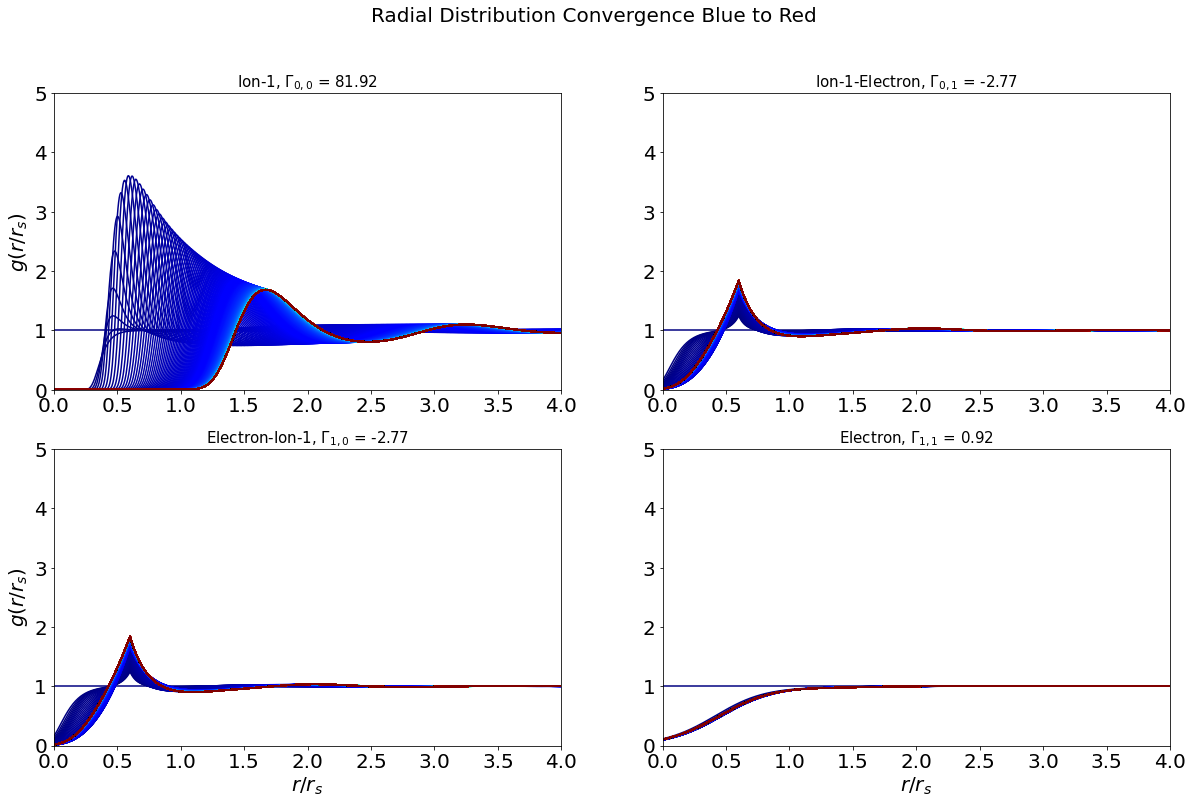

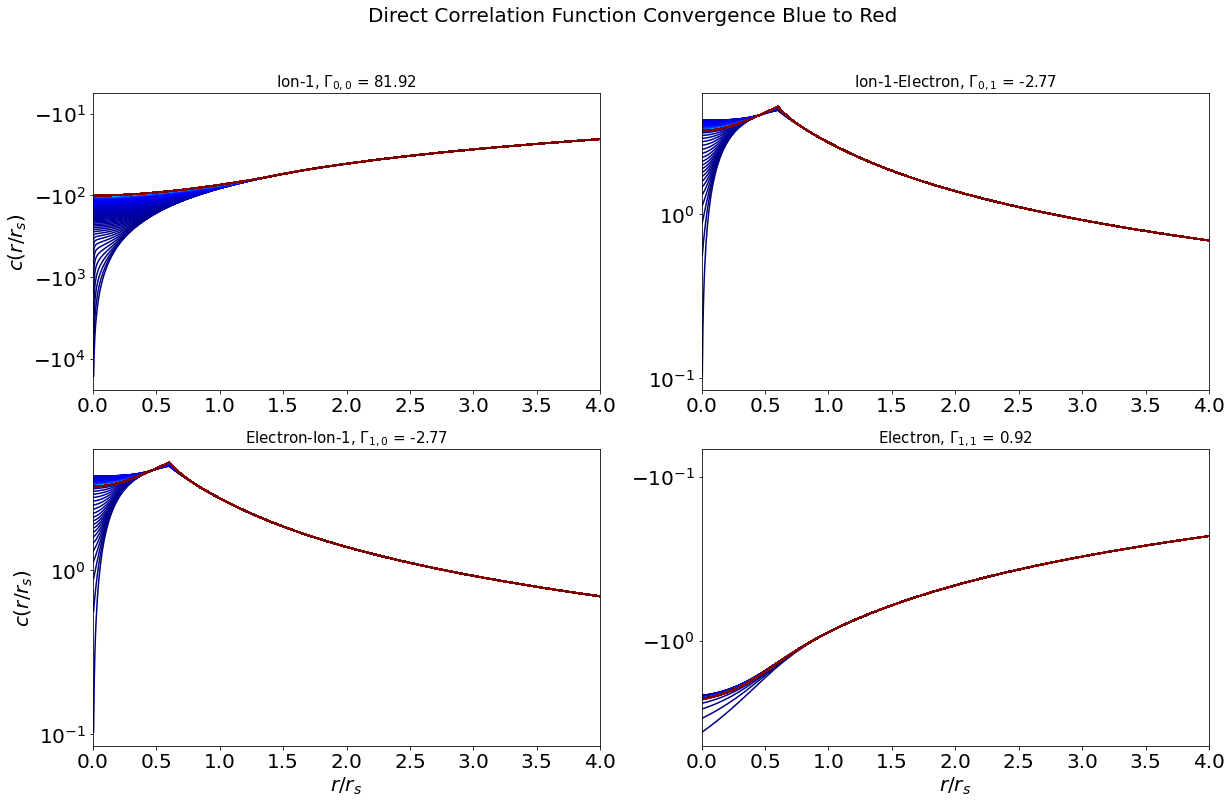

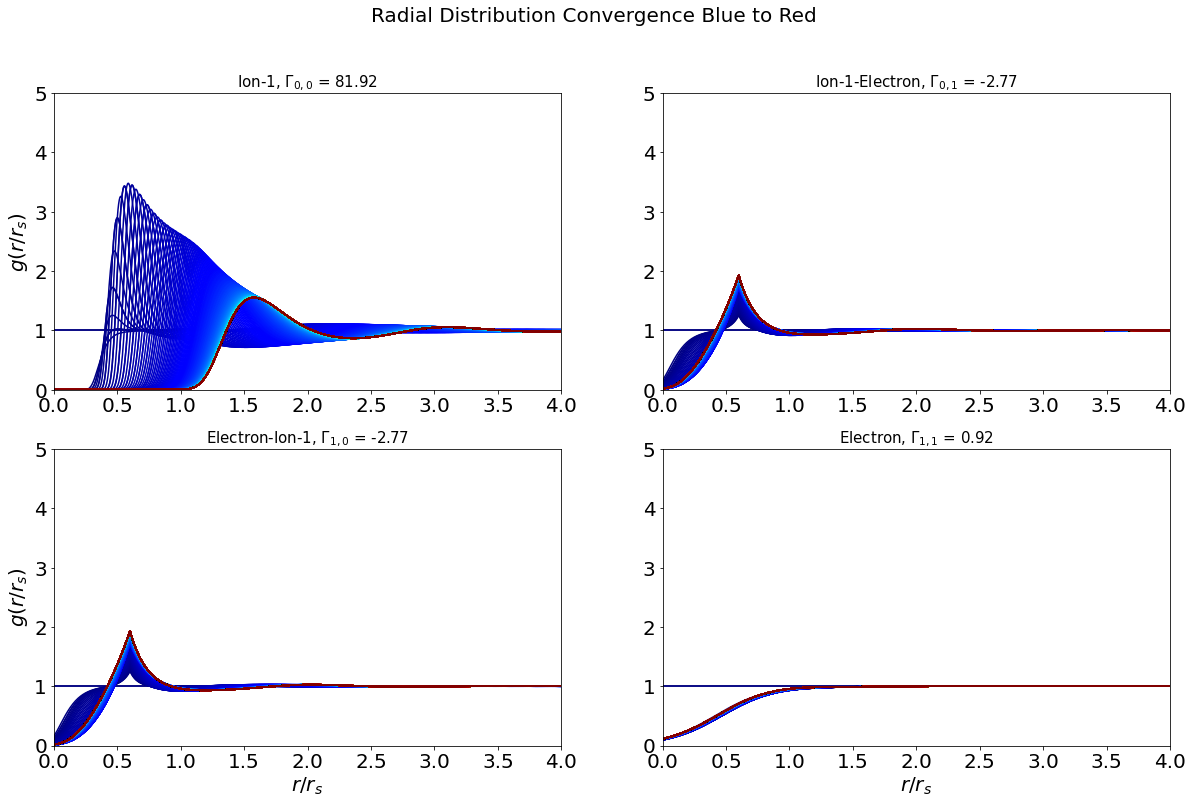

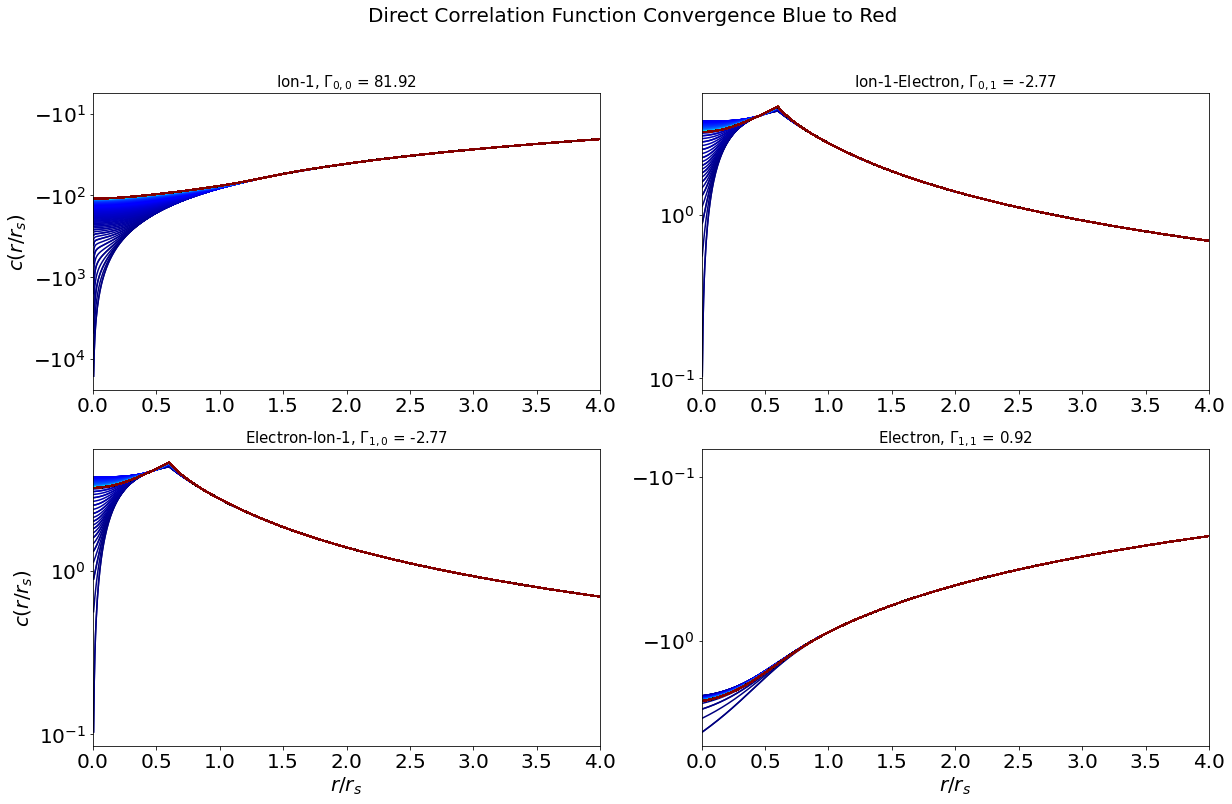

In [13]:
aluminum.plot_species_convergence_g(n_slices= int(len(aluminum.h_list)/1)  )
aluminum.plot_species_convergence_c(n_slices= int(len(aluminum.h_list)/1)  )
aluminumSVT.plot_species_convergence_g(n_slices= int(len(aluminum.h_list)/1)  )
aluminumSVT.plot_species_convergence_c(n_slices= int(len(aluminum.h_list)/1)  )

In [38]:
Al_file = "/home/zach/plasma/datasets/RDFs/Al_1.0eV_rs3_VASP.txt"  # 1 eV
Al_file = '/home/zach/plasma/datasets/RDFs/Al_0.5eV_rs3_KS-MD.txt' # 0.5 eV
Al_data = read_csv(Al_file,header=0, names=['r','g'])

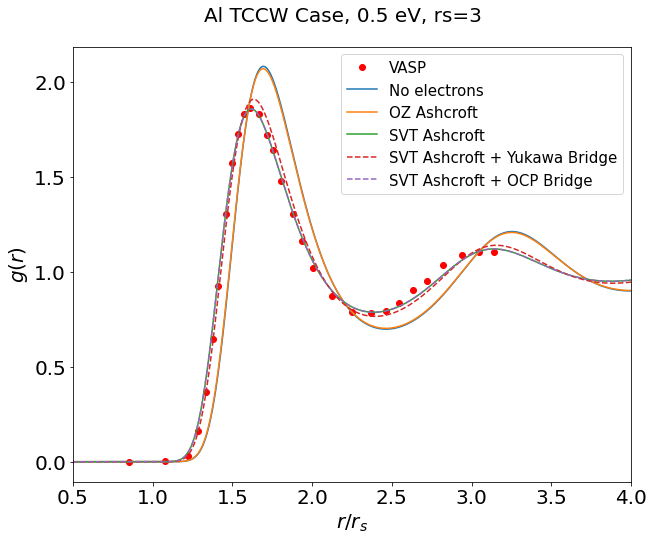

In [40]:
fig, ax = plt.subplots(figsize=(10,8))
fig.suptitle('Al TCCW Case, 0.5 eV, rs=3', fontsize=20, y=0.95)

ax.plot(Al_data['r'], Al_data['g'],'ro', label = 'VASP' )
ax.plot(aluminum.r_array, aluminum_one_species.h_r_matrix[0,0] + 1, label='No electrons')
ax.plot(aluminum.r_array, aluminum.h_r_matrix[0,0] + 1, label='OZ Ashcroft')
ax.plot(aluminum.r_array, aluminumSVT.h_r_matrix[0,0] + 1, label='SVT Ashcroft')
ax.plot(aluminum.r_array, aluminumSVT_Yuk.h_r_matrix[0,0] + 1,'--', label='SVT Ashcroft + Yukawa Bridge')
ax.plot(aluminum.r_array, aluminumSVT_OCP.h_r_matrix[0,0] + 1,'--', label='SVT Ashcroft + OCP Bridge')

aluminumSVT_Yuk

ax.set_ylabel(r'$g(r)$',fontsize=20)
ax.set_xlabel(r'$r/r_s$',fontsize=20)
ax.tick_params(labelsize=20)
ax.set_xlim(0.5,4)
ax.legend(fontsize=15)
